# Project - Unsupervised Learning

# PART I

### DOMAIN: Automobile
### CONTEXT: 
The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes
### DATA DESCRIPTION: 
The data concerns city-cycle fuel consumption in miles per gallon

### Attribute Information:
1. mpg: continuous
2. cylinders: multi-valued discrete
3. displacement: continuous
4. horsepower: continuous
5. weight: continuous
6. acceleration: continuous
7. model year: multi-valued discrete
8. origin: multi-valued discrete
9. car name: string (unique for each instance)

### PROJECT OBJECTIVE: 
Goal is to cluster the data and treat them as individual datasets to train Regression models to predict ‘mpg’

## 1. Import and warehouse data:

In [1]:
#Loading the required packages
import numpy as np
import pandas as pd    
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import json
from IPython.display import display

%matplotlib inline 
sns.set(color_codes=True)
%matplotlib inline

from sklearn.linear_model import LinearRegression
from scipy import stats 
from scipy.stats import zscore
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

#Ignoring Warnings
import warnings
warnings.filterwarnings('ignore')

##### • Import all the given datasets and explore shape and size.

In [2]:
#import all the data set

#Loading the json file and concatinating it with car names
ca=pd.read_json('Part1 - Car-Attributes.json')
ca1=pd.read_csv('Part1 - Car name.csv')
ca.head()

mpg  cyl   disp   hp    wt   acc  yr  origin
0  18.0    8  307.0  130  3504  12.0  70       1
1  15.0    8  350.0  165  3693  11.5  70       1
2  18.0    8  318.0  150  3436  11.0  70       1
3  16.0    8  304.0  150  3433  12.0  70       1
4  17.0    8  302.0  140  3449  10.5  70       1

In [3]:
ca1.head()

car_name
0  chevrolet chevelle malibu
1          buick skylark 320
2         plymouth satellite
3              amc rebel sst
4                ford torino

##### • Merge all datasets onto one and explore final shape and size.

In [4]:
car=pd.concat([ca,ca1],axis=1,join='inner')
car.head()

mpg  cyl   disp   hp    wt   acc  yr  origin                   car_name
0  18.0    8  307.0  130  3504  12.0  70       1  chevrolet chevelle malibu
1  15.0    8  350.0  165  3693  11.5  70       1          buick skylark 320
2  18.0    8  318.0  150  3436  11.0  70       1         plymouth satellite
3  16.0    8  304.0  150  3433  12.0  70       1              amc rebel sst
4  17.0    8  302.0  140  3449  10.5  70       1                ford torino

In [5]:
print(car.shape)
print(car.size)
row, column =car.shape
print('The dataset contains', row, 'rows and', column, 'columns')

(398, 9)
3582
The dataset contains 398 rows and 9 columns


###### • Export the final dataset and store it on local machine in .csv, .xlsx and .json format for future use.

In [6]:
# save this data as to csv,xlsx and json
car.to_csv('mpg.csv', index=False)
car.to_excel('mpg.xlsx', index=False)
car.to_json('mpg.json', orient='split', compression='infer', index='true')

###### • Import the data from above steps into python.

In [7]:
ca_csv=pd.read_csv('mpg.csv')
ca_excel=pd.read_excel('mpg.xlsx')
ca_json=pd.read_json('mpg.json', orient='split', compression='infer')
ca_json.head()

mpg  cyl   disp   hp    wt   acc  yr  origin                   car_name
0  18.0    8  307.0  130  3504  12.0  70       1  chevrolet chevelle malibu
1  15.0    8  350.0  165  3693  11.5  70       1          buick skylark 320
2  18.0    8  318.0  150  3436  11.0  70       1         plymouth satellite
3  16.0    8  304.0  150  3433  12.0  70       1              amc rebel sst
4  17.0    8  302.0  140  3449  10.5  70       1                ford torino

# 2. Data cleansing: 

In [8]:
#• Missing/incorrect value treatment
#• Drop attribute/s if required using relevant functional knowledge
#• Perform another kind of corrections/treatment on the data.

In [9]:
#dropping/ignoring car_name 
car = car.drop('car_name', axis=1)

In [10]:
car

mpg  cyl   disp   hp    wt   acc  yr  origin
0    18.0    8  307.0  130  3504  12.0  70       1
1    15.0    8  350.0  165  3693  11.5  70       1
2    18.0    8  318.0  150  3436  11.0  70       1
3    16.0    8  304.0  150  3433  12.0  70       1
4    17.0    8  302.0  140  3449  10.5  70       1
..    ...  ...    ...  ...   ...   ...  ..     ...
393  27.0    4  140.0   86  2790  15.6  82       1
394  44.0    4   97.0   52  2130  24.6  82       2
395  32.0    4  135.0   84  2295  11.6  82       1
396  28.0    4  120.0   79  2625  18.6  82       1
397  31.0    4  119.0   82  2720  19.4  82       1

[398 rows x 8 columns]

In [11]:
# Replacing the categorical var with actual values
car['origin'] = car['origin'].replace({1: 'america', 2: 'europe', 3: 'asia'})
car.head()

mpg  cyl   disp   hp    wt   acc  yr   origin
0  18.0    8  307.0  130  3504  12.0  70  america
1  15.0    8  350.0  165  3693  11.5  70  america
2  18.0    8  318.0  150  3436  11.0  70  america
3  16.0    8  304.0  150  3433  12.0  70  america
4  17.0    8  302.0  140  3449  10.5  70  america

In [12]:
print('The data type of each attribute: \n')
car.info()

The data type of each attribute: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mpg     398 non-null    float64
 1   cyl     398 non-null    int64  
 2   disp    398 non-null    float64
 3   hp      398 non-null    object 
 4   wt      398 non-null    int64  
 5   acc     398 non-null    float64
 6   yr      398 non-null    int64  
 7   origin  398 non-null    object 
dtypes: float64(3), int64(3), object(2)
memory usage: 25.0+ KB


In [13]:
#5-point summary
car.describe().T

count         mean         std     min       25%     50%       75%  \
mpg   398.0    23.514573    7.815984     9.0    17.500    23.0    29.000   
cyl   398.0     5.454774    1.701004     3.0     4.000     4.0     8.000   
disp  398.0   193.425879  104.269838    68.0   104.250   148.5   262.000   
wt    398.0  2970.424623  846.841774  1613.0  2223.750  2803.5  3608.000   
acc   398.0    15.568090    2.757689     8.0    13.825    15.5    17.175   
yr    398.0    76.010050    3.697627    70.0    73.000    76.0    79.000   

         max  
mpg     46.6  
cyl      8.0  
disp   455.0  
wt    5140.0  
acc     24.8  
yr      82.0

In [14]:
# isdigit()? on 'horsepower'
hpIsDigit = pd.DataFrame(car.hp.str.isdigit())

#print isDigit = False!
car[hpIsDigit['hp'] == False]

mpg  cyl   disp hp    wt   acc  yr   origin
32   25.0    4   98.0  ?  2046  19.0  71  america
126  21.0    6  200.0  ?  2875  17.0  74  america
330  40.9    4   85.0  ?  1835  17.3  80   europe
336  23.6    4  140.0  ?  2905  14.3  80  america
354  34.5    4  100.0  ?  2320  15.8  81   europe
374  23.0    4  151.0  ?  3035  20.5  82  america

In [15]:
# Replace missing values with NaN
car = car.replace('?', np.nan)
car[hpIsDigit['hp'] == False] 

mpg  cyl   disp  hp    wt   acc  yr   origin
32   25.0    4   98.0 NaN  2046  19.0  71  america
126  21.0    6  200.0 NaN  2875  17.0  74  america
330  40.9    4   85.0 NaN  1835  17.3  80   europe
336  23.6    4  140.0 NaN  2905  14.3  80  america
354  34.5    4  100.0 NaN  2320  15.8  81   europe
374  23.0    4  151.0 NaN  3035  20.5  82  america

In [16]:
#replace the missing values with median value. 
car.median()
#car.hp.median()

mpg       23.0
cyl        4.0
disp     148.5
hp        93.5
wt      2803.5
acc       15.5
yr        76.0
dtype: float64

In [17]:
#replace hp with median
car['hp'].fillna((car['hp'].median()), inplace=True)

In [18]:
print('The data set has no missing values \n')
car.isnull().sum()

The data set has no missing values 



mpg       0
cyl       0
disp      0
hp        0
wt        0
acc       0
yr        0
origin    0
dtype: int64

In [19]:
#creating mpg_level attribute using the 25% and 75% of mpg values( <  17 as low, > 17 and <29 as medium, > 29 as high  )
car['mpg_level'] = car['mpg'].apply(lambda x: 'low' if x<17 else 'high' if x>29 else 'medium')
car.head()

mpg  cyl   disp     hp    wt   acc  yr   origin mpg_level
0  18.0    8  307.0  130.0  3504  12.0  70  america    medium
1  15.0    8  350.0  165.0  3693  11.5  70  america       low
2  18.0    8  318.0  150.0  3436  11.0  70  america    medium
3  16.0    8  304.0  150.0  3433  12.0  70  america       low
4  17.0    8  302.0  140.0  3449  10.5  70  america    medium

In [20]:
car.head()

mpg  cyl   disp     hp    wt   acc  yr   origin mpg_level
0  18.0    8  307.0  130.0  3504  12.0  70  america    medium
1  15.0    8  350.0  165.0  3693  11.5  70  america       low
2  18.0    8  318.0  150.0  3436  11.0  70  america    medium
3  16.0    8  304.0  150.0  3433  12.0  70  america       low
4  17.0    8  302.0  140.0  3449  10.5  70  america    medium

In [21]:
#categorical variable
car_cat = car.iloc[:,[1,6,7,8]]
car_cat.head()

cyl  yr   origin mpg_level
0    8  70  america    medium
1    8  70  america       low
2    8  70  america    medium
3    8  70  america       low
4    8  70  america    medium

In [22]:
#numeric variables
car_num=car.drop(['cyl','yr','origin','mpg_level'],axis=1)
car_num.head()

mpg   disp     hp    wt   acc
0  18.0  307.0  130.0  3504  12.0
1  15.0  350.0  165.0  3693  11.5
2  18.0  318.0  150.0  3436  11.0
3  16.0  304.0  150.0  3433  12.0
4  17.0  302.0  140.0  3449  10.5

# 3. Data analysis & visualisation:

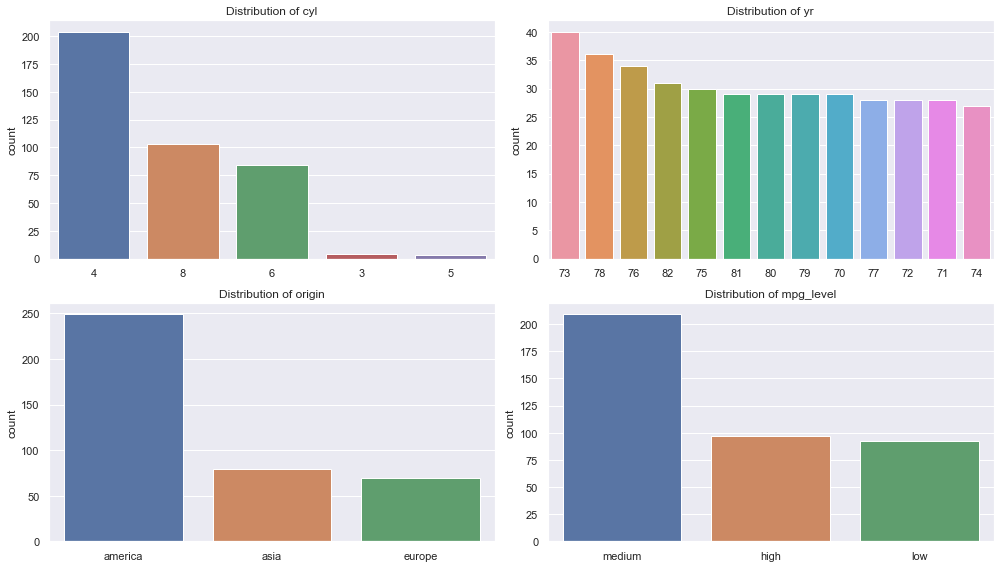

In [23]:
#plotting categorical variables
fig = plt.figure(1, (14, 8))

for i,car in enumerate(car_cat.columns):
    ax = plt.subplot(2,2,i+1)
    sns.countplot(car_cat[car], order=car_cat[car].value_counts().index)
    ax.set_xlabel(None)
    ax.set_title(f'Distribution of {car}')
    plt.tight_layout()

plt.show()

American 4 cylinder cars produced in 1973 with medium mpg level seem to dominate the dateset

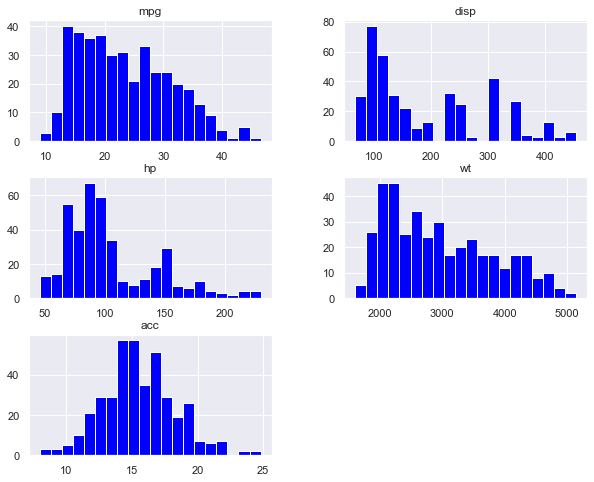

In [24]:
#plot histograms
car_num.hist(bins = 20, figsize = (10, 8), color = 'blue')
plt.show()

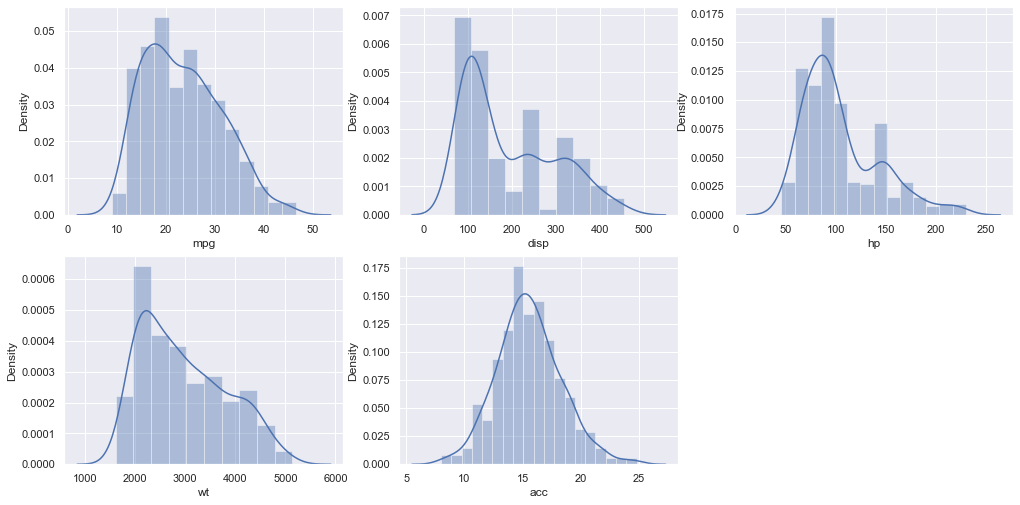

In [25]:
#plot density
plt.figure(figsize=(17, 13))
col = 1
for i in car_num.columns:
    plt.subplot(3, 3, col)
    sns.distplot(car_num[i], color = 'b')
    col += 1 

Displacement and Horsepower seem to be skewed to the right

In [26]:
#joining the categorical and numerical variables
car=pd.concat([car_cat,car_num],axis=1)

In [27]:
#checking for attribute type
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   cyl        398 non-null    int64  
 1   yr         398 non-null    int64  
 2   origin     398 non-null    object 
 3   mpg_level  398 non-null    object 
 4   mpg        398 non-null    float64
 5   disp       398 non-null    float64
 6   hp         398 non-null    float64
 7   wt         398 non-null    int64  
 8   acc        398 non-null    float64
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [28]:
car.head()

cyl  yr   origin mpg_level   mpg   disp     hp    wt   acc
0    8  70  america    medium  18.0  307.0  130.0  3504  12.0
1    8  70  america       low  15.0  350.0  165.0  3693  11.5
2    8  70  america    medium  18.0  318.0  150.0  3436  11.0
3    8  70  america       low  16.0  304.0  150.0  3433  12.0
4    8  70  america    medium  17.0  302.0  140.0  3449  10.5

In [29]:
# Perform detailed statistical analysis on the data

display(car.describe())

cyl          yr         mpg        disp          hp  \
count  398.000000  398.000000  398.000000  398.000000  398.000000   
mean     5.454774   76.010050   23.514573  193.425879  104.304020   
std      1.701004    3.697627    7.815984  104.269838   38.222625   
min      3.000000   70.000000    9.000000   68.000000   46.000000   
25%      4.000000   73.000000   17.500000  104.250000   76.000000   
50%      4.000000   76.000000   23.000000  148.500000   93.500000   
75%      8.000000   79.000000   29.000000  262.000000  125.000000   
max      8.000000   82.000000   46.600000  455.000000  230.000000   

                wt         acc  
count   398.000000  398.000000  
mean   2970.424623   15.568090  
std     846.841774    2.757689  
min    1613.000000    8.000000  
25%    2223.750000   13.825000  
50%    2803.500000   15.500000  
75%    3608.000000   17.175000  
max    5140.000000   24.800000

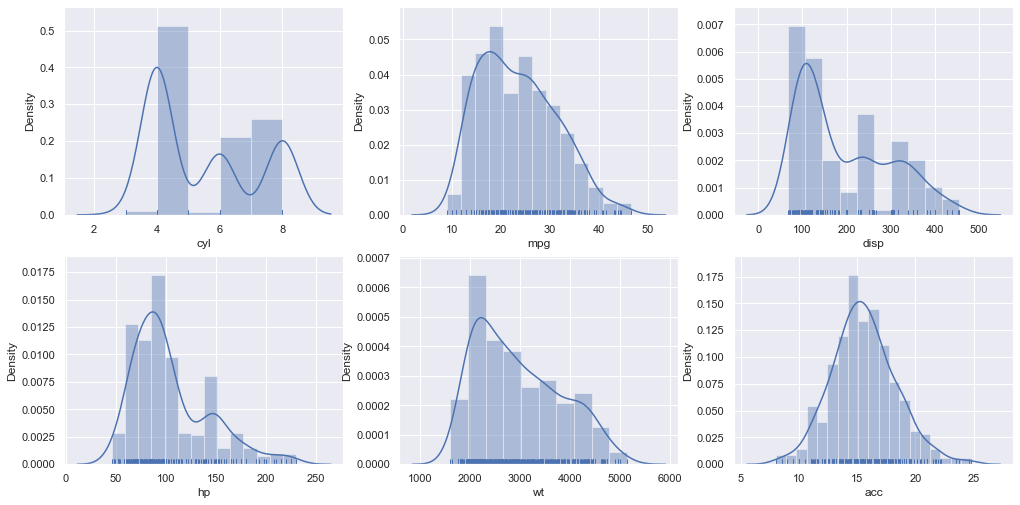

In [30]:
# Univariate analysis
plt.figure(figsize=(17, 13))
col = 1
for i in car.drop(['yr','origin','mpg_level'],axis=1).columns:
    plt.subplot(3, 3, col)
    sns.distplot(car[i], color = 'b', rug = True)
    col += 1

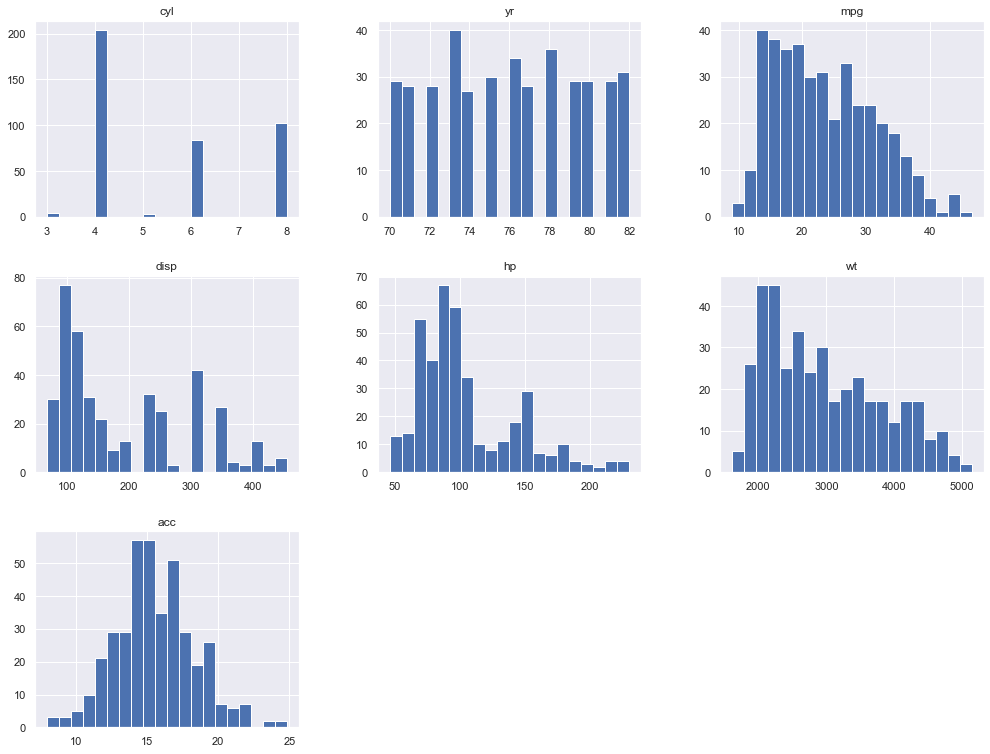

In [31]:
# let's visualize the distribution of the features of the cars
# Univariate analysis
car.hist(figsize=(17,13),bins=20)
plt.show()

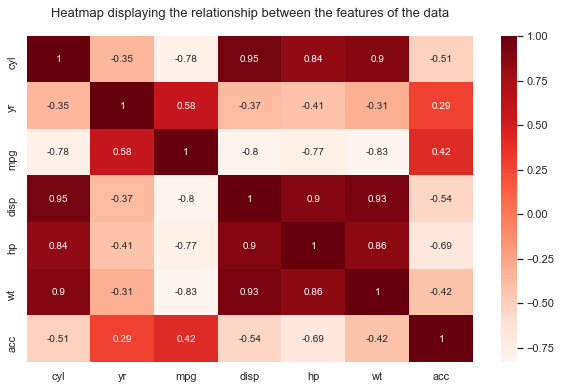

In [32]:
# Let's visualize the relationships between the mpg of a car and the other features.
# Bivariate analysis

plt.figure(figsize=(10,6))
sns.heatmap(car.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data\n', fontsize=13)
plt.show()

Mpg column is having good corelation on cyl,disp,wt

cyl ,disp and wt and hp are having negative corelation

next will check the data distribution using the pair plot

In [33]:
print(car.shape)
print(car.size)

(398, 9)
3582


In [34]:
#create dummy varibale for mpg_level and origin and creating a seperate datset for k-means and heirarchical clustering
car = pd.get_dummies(car, columns=['origin'])
car = pd.get_dummies(car, columns=['mpg_level'])
car.head()
carH=car.copy()
carK=car.copy()

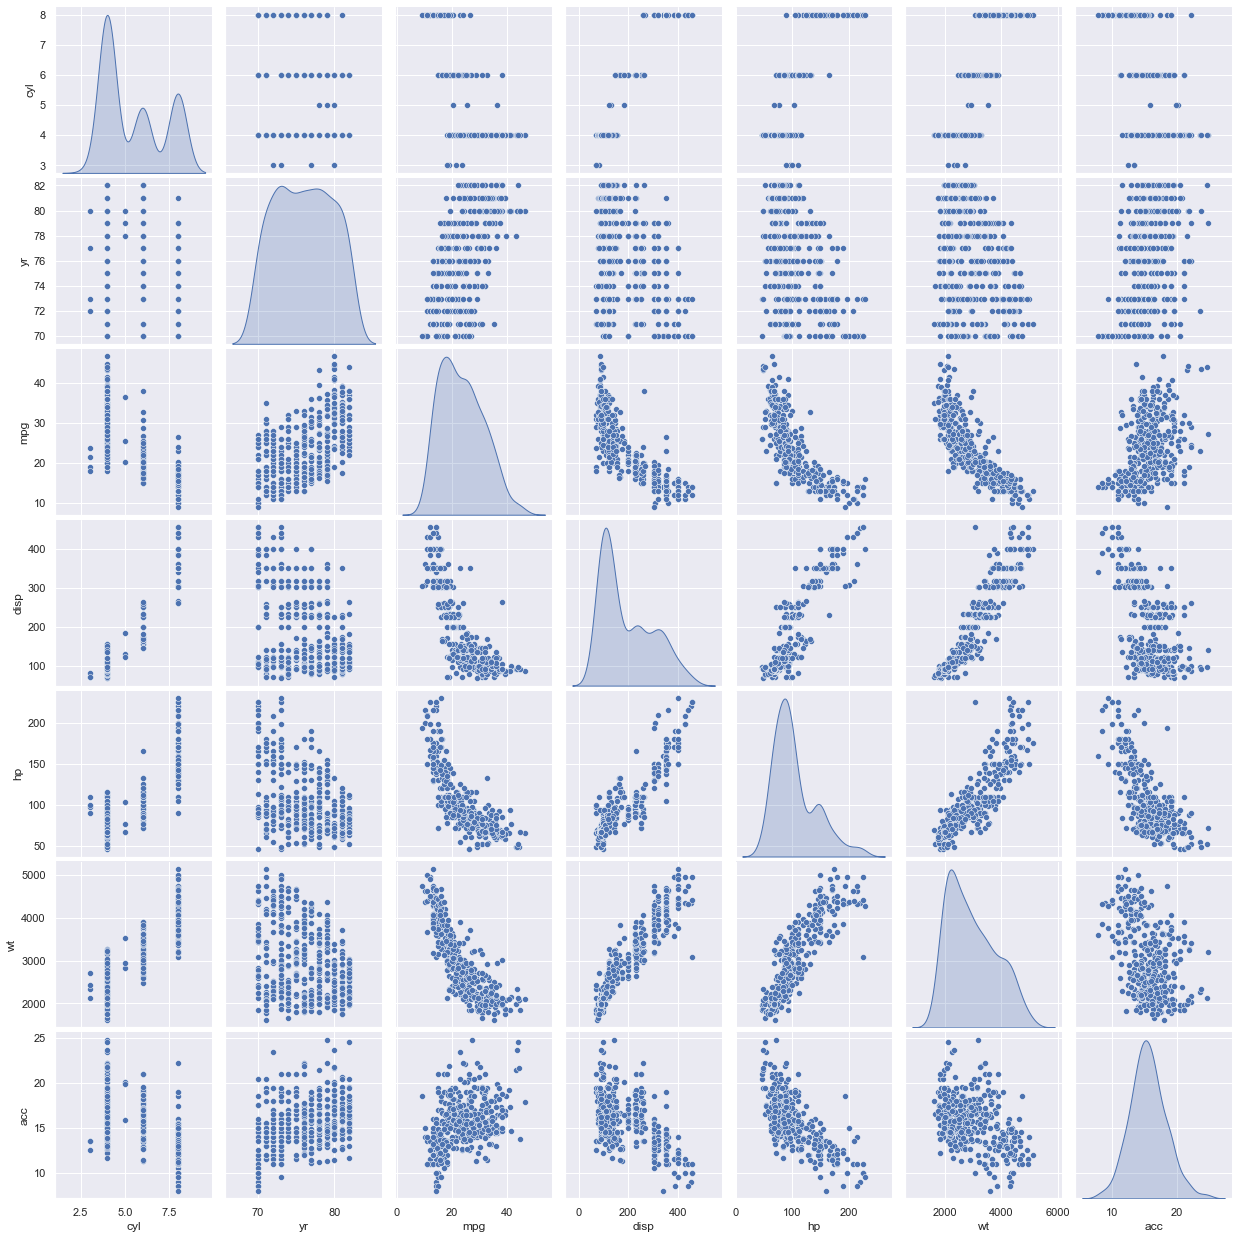

In [35]:
#pair plot for the numeric attributes
car_attr = car.iloc[:, 0:7]
sns.pairplot(car_attr, diag_kind='kde');

There appears to be a linear relationship between the variables

In [36]:
car.head()

cyl  yr   mpg   disp     hp    wt   acc  origin_america  origin_asia  \
0    8  70  18.0  307.0  130.0  3504  12.0               1            0   
1    8  70  15.0  350.0  165.0  3693  11.5               1            0   
2    8  70  18.0  318.0  150.0  3436  11.0               1            0   
3    8  70  16.0  304.0  150.0  3433  12.0               1            0   
4    8  70  17.0  302.0  140.0  3449  10.5               1            0   

   origin_europe  mpg_level_high  mpg_level_low  mpg_level_medium  
0              0               0              0                 1  
1              0               0              1                 0  
2              0               0              0                 1  
3              0               0              1                 0  
4              0               0              0                 1

In [37]:
#dropping the created dummy variable
car2=car.drop(['origin_america','origin_asia','origin_europe','mpg_level_high','mpg_level_low','mpg_level_medium'],axis=1)

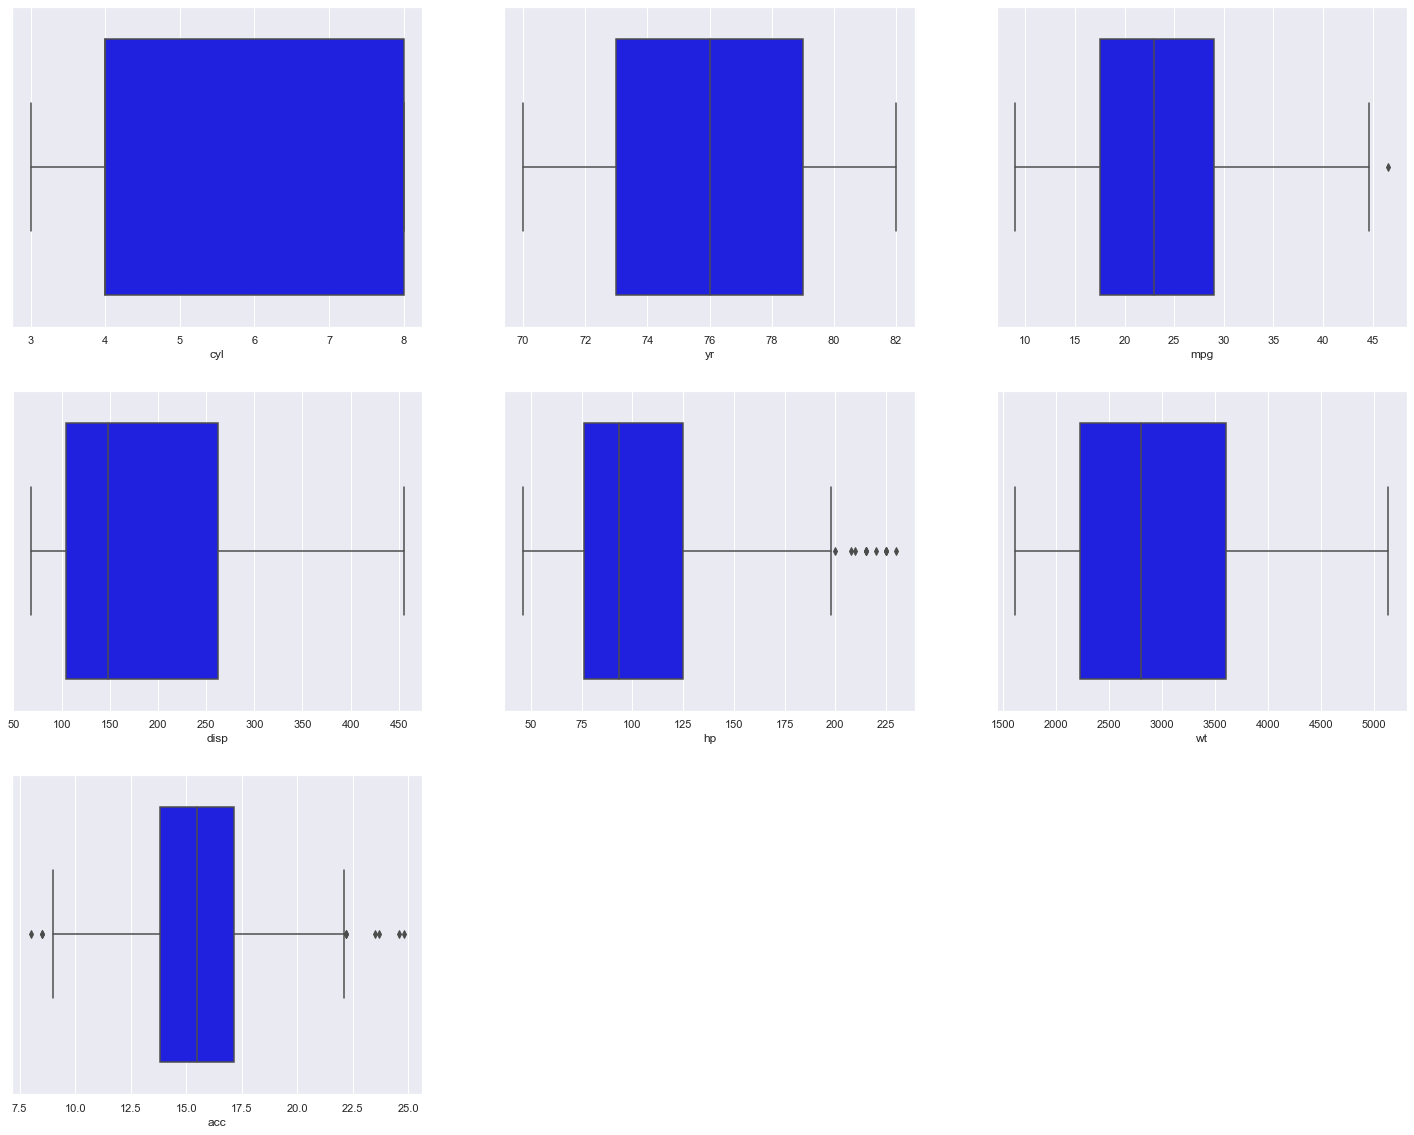

In [38]:
#checking of outliers
plt.figure(figsize=(25, 20))
col = 1
for i in car2.columns:
    plt.subplot(3, 3, col)
    sns.boxplot(car2[i],color='blue')
    col += 1

In [39]:
#replacing outliers with IQR (Q1 and Q3 +-1.5*IQR)
IQR1 = stats.iqr(car2['hp'], interpolation = 'midpoint')
IQR2 = stats.iqr(car2['acc'], interpolation = 'midpoint')

In [40]:
print(IQR1)
print(IQR2)

49.0
3.299999999999997


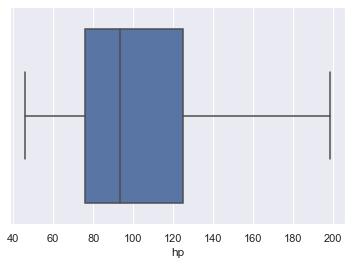

In [41]:
# Horsepower after imputing outliers
Q3 = car2['hp'].quantile(0.75)
car2['hp'] = np.where(car2["hp"] >(Q3+1.5*IQR1), 198.5,car2['hp'])
sns.boxplot(car2['hp']);

13.825000000000001
17.174999999999997


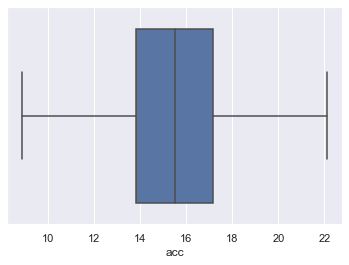

In [42]:
#accelaration after imputing outliers
Q1 = car2['acc'].quantile(0.25)
Q31=car2['acc'].quantile(0.75)
print(Q1)
print(Q31)
car2['acc'] = np.where(car2["acc"] >(Q31+1.5*IQR2),22.10 ,car2['acc'])
car2['acc'] = np.where(car2["acc"] <(Q1-1.5*IQR2),(Q1-1.5*IQR2),car2['acc'])
sns.boxplot(car2['acc']);

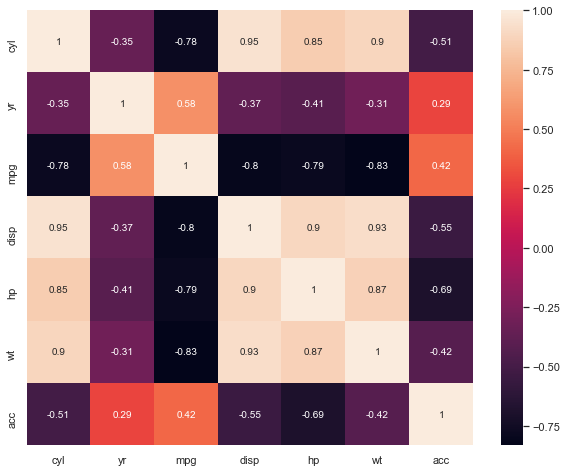

In [43]:
#checking for correlation
plt.figure(figsize=(10,8))
corr=car2.corr()
sns.heatmap(corr,annot=True);

Except Year, most of the variable are correlated with each other

# 4. Machine learning:

## Heirarchical Clustering

In [44]:
car.head()

cyl  yr   mpg   disp     hp    wt   acc  origin_america  origin_asia  \
0    8  70  18.0  307.0  130.0  3504  12.0               1            0   
1    8  70  15.0  350.0  165.0  3693  11.5               1            0   
2    8  70  18.0  318.0  150.0  3436  11.0               1            0   
3    8  70  16.0  304.0  150.0  3433  12.0               1            0   
4    8  70  17.0  302.0  140.0  3449  10.5               1            0   

   origin_europe  mpg_level_high  mpg_level_low  mpg_level_medium  
0              0               0              0                 1  
1              0               0              1                 0  
2              0               0              0                 1  
3              0               0              1                 0  
4              0               0              0                 1

In [45]:
#separating numeric variables
cc = car.iloc[:,0:7] 
cc.head()

cyl  yr   mpg   disp     hp    wt   acc
0    8  70  18.0  307.0  130.0  3504  12.0
1    8  70  15.0  350.0  165.0  3693  11.5
2    8  70  18.0  318.0  150.0  3436  11.0
3    8  70  16.0  304.0  150.0  3433  12.0
4    8  70  17.0  302.0  140.0  3449  10.5

In [46]:
#scaling the variable
cc_z = cc.apply(zscore)
cc_z.head()

cyl        yr       mpg      disp        hp        wt       acc
0  1.498191 -1.627426 -0.706439  1.090604  0.673118  0.630870 -1.295498
1  1.498191 -1.627426 -1.090751  1.503514  1.589958  0.854333 -1.477038
2  1.498191 -1.627426 -0.706439  1.196232  1.197027  0.550470 -1.658577
3  1.498191 -1.627426 -0.962647  1.061796  1.197027  0.546923 -1.295498
4  1.498191 -1.627426 -0.834543  1.042591  0.935072  0.565841 -1.840117

In [47]:
#calculating pairwise distance using average linkage method
link_method = linkage(cc_z.iloc[:,0:7], method = 'average')

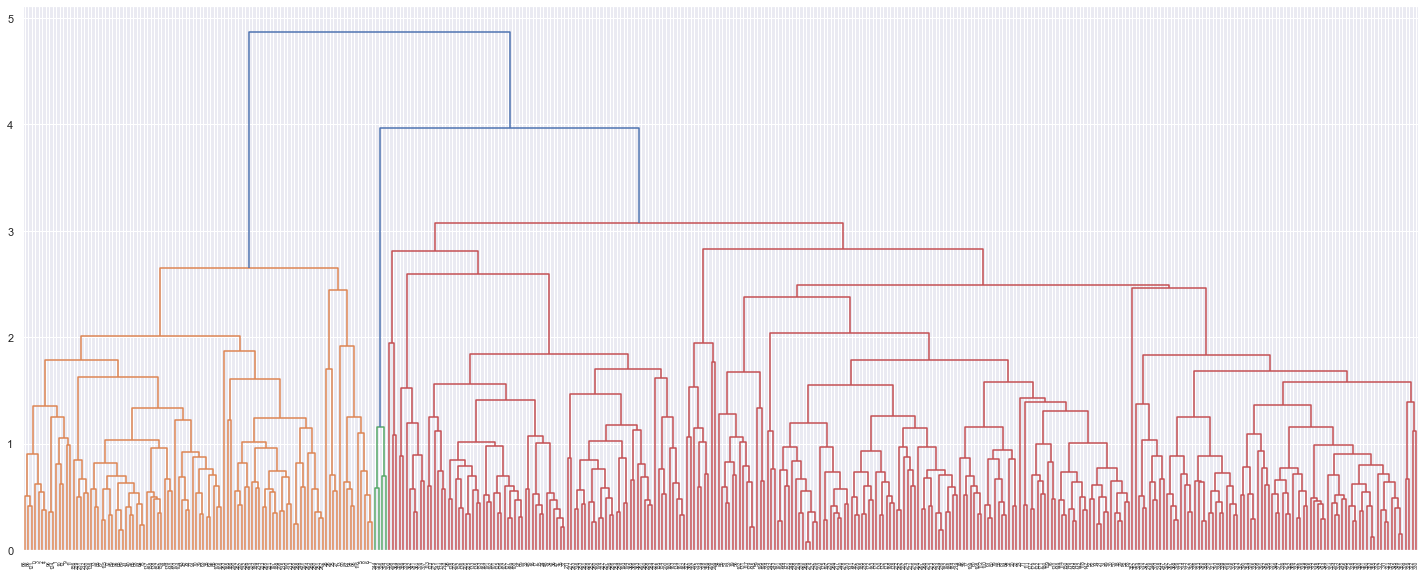

In [48]:
#plotting the H-cluster
plt.figure(figsize=(25, 10))
dendrogram(link_method)
plt.show()

Appers to be to much of a visual clutter, we'll go ahead and cut down the dendrogram to give us 2 clusters/groups

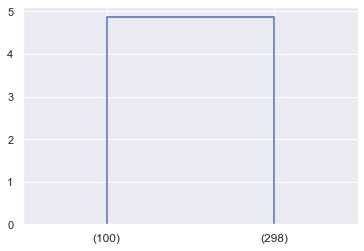

In [49]:
# dendrogram function to arrive at dendrogram
dendrogram(
    link_method,
    truncate_mode='lastp',  
    p=2,  
)
plt.show()

In [50]:
#vieweing the clusters formed
clusters = fcluster(link_method, 2, criterion='maxclust')
clusters

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,

In [51]:
#attaching the clusters formed to the scales data
cc_z['clusters_H'] = clusters
cc_z.head()

cyl        yr       mpg      disp        hp        wt       acc  \
0  1.498191 -1.627426 -0.706439  1.090604  0.673118  0.630870 -1.295498   
1  1.498191 -1.627426 -1.090751  1.503514  1.589958  0.854333 -1.477038   
2  1.498191 -1.627426 -0.706439  1.196232  1.197027  0.550470 -1.658577   
3  1.498191 -1.627426 -0.962647  1.061796  1.197027  0.546923 -1.295498   
4  1.498191 -1.627426 -0.834543  1.042591  0.935072  0.565841 -1.840117   

   clusters_H  
0           1  
1           1  
2           1  
3           1  
4           1

In [52]:
#vieweing the distribution of clusters
cc_z.clusters_H.value_counts().sort_index()

1    100
2    298
Name: clusters_H, dtype: int64

In [53]:
#attaching the clusters formed to the original data
cc['clusters_H']=clusters
carH['clusters_H']=clusters
cc.head()

cyl  yr   mpg   disp     hp    wt   acc  clusters_H
0    8  70  18.0  307.0  130.0  3504  12.0           1
1    8  70  15.0  350.0  165.0  3693  11.5           1
2    8  70  18.0  318.0  150.0  3436  11.0           1
3    8  70  16.0  304.0  150.0  3433  12.0           1
4    8  70  17.0  302.0  140.0  3449  10.5           1

In [54]:
#create a new data set named Hclus
Hclus=cc
Hclus.head()

cyl  yr   mpg   disp     hp    wt   acc  clusters_H
0    8  70  18.0  307.0  130.0  3504  12.0           1
1    8  70  15.0  350.0  165.0  3693  11.5           1
2    8  70  18.0  318.0  150.0  3436  11.0           1
3    8  70  16.0  304.0  150.0  3433  12.0           1
4    8  70  17.0  302.0  140.0  3449  10.5           1

In [55]:
#aggregating the numerical variable with the clusters formed with the mean
aggdata=cc.iloc[:,0:8].groupby('clusters_H').mean()
aggdata['Freq']=cc.clusters_H.value_counts().sort_index()
aggdata

cyl         yr        mpg        disp          hp  \
clusters_H                                                           
1           7.980000  73.740000  14.684000  345.470000  160.400000   
2           4.607383  76.771812  26.477852  142.404362   85.479866   

                     wt        acc  Freq  
clusters_H                                
1           4121.560000  12.702000   100  
2           2584.137584  16.529866   298

##### Clearly shows two disting group with a difference in average between the clusters and variables

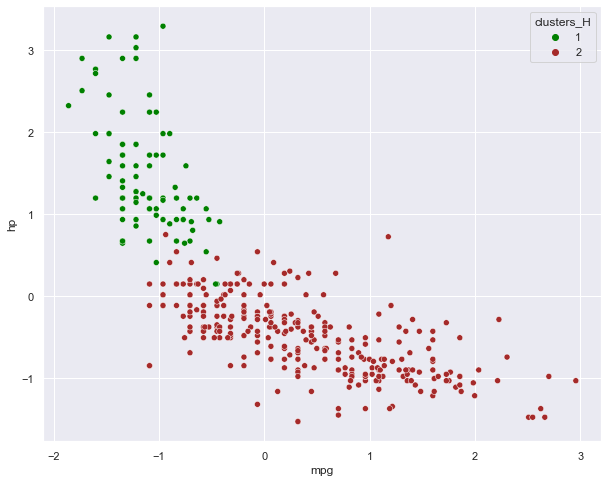

In [56]:
#plotting the clusters formed
plt.figure(figsize=(10, 8))
sns.scatterplot(x="mpg", y="hp", hue="clusters_H",
              data=cc_z, 
                    palette=['green','brown']);

## K-Means Clustering

In [57]:
#seperating the numeric values
cc = car.iloc[:,0:7] 
cc_z1 = cc.apply(zscore)
cc_z1.head()

cyl        yr       mpg      disp        hp        wt       acc
0  1.498191 -1.627426 -0.706439  1.090604  0.673118  0.630870 -1.295498
1  1.498191 -1.627426 -1.090751  1.503514  1.589958  0.854333 -1.477038
2  1.498191 -1.627426 -0.706439  1.196232  1.197027  0.550470 -1.658577
3  1.498191 -1.627426 -0.962647  1.061796  1.197027  0.546923 -1.295498
4  1.498191 -1.627426 -0.834543  1.042591  0.935072  0.565841 -1.840117

In [58]:
# Calculating the within sum of squares(WSS)
wss =[] 
for i in range(1,5):
    KM = KMeans(n_clusters=i)
    KM.fit(cc_z1)
    wss.append(KM.inertia_)
wss

[2785.9999999999995, 1294.8418950727319, 946.0197908553791, 738.393223592467]

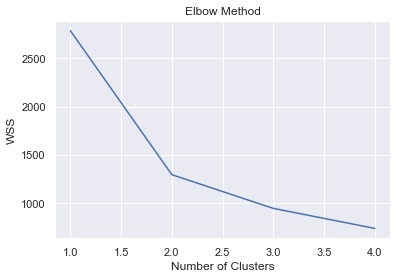

In [59]:
#plotting the WSS against the number of cluster to come up with optimal number of clusters using Elbow-method
plt.plot(range(1,5), wss);
plt.title('Elbow Method');
plt.xlabel("Number of Clusters")
plt.ylabel("WSS");

In [60]:
#using 2 centroids for clustering
k_means = KMeans(n_clusters = 2)
k_means.fit(cc_z1)
labels = k_means.labels_

In [61]:
# Calculating silhouette_score
silhouette_score(cc_z1,labels)

0.48235946103916116

In [62]:
#calculating silhouette score for different centroids
kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
}


silhouette_coefficients = []

 # Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(cc_z1)
    score = silhouette_score(cc_z1,kmeans.labels_)
    silhouette_coefficients.append(score)

silhouette_coefficients

[0.48235946103916116,
 0.35314791198988205,
 0.34844881731503,
 0.31333733812964754,
 0.2739586189486065]

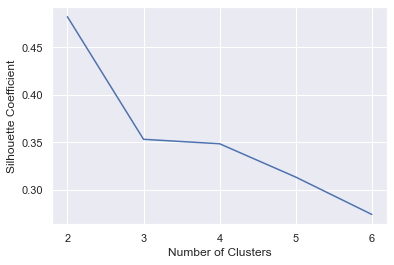

In [63]:
#plotting silhouette score for different centroids
plt.plot(range(2, 7), silhouette_coefficients)
plt.xticks(range(2, 7))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [64]:
#attaching the labels to the datasets
cc["cluster_K"] = labels
carK['cluster_K']=labels
Kclus=cc
Kclus.head()

cyl  yr   mpg   disp     hp    wt   acc  cluster_K
0    8  70  18.0  307.0  130.0  3504  12.0          1
1    8  70  15.0  350.0  165.0  3693  11.5          1
2    8  70  18.0  318.0  150.0  3436  11.0          1
3    8  70  16.0  304.0  150.0  3433  12.0          1
4    8  70  17.0  302.0  140.0  3449  10.5          1

In [65]:
#vieweing the distribution of clusters
cc.cluster_K.value_counts().sort_index()

0    293
1    105
Name: cluster_K, dtype: int64

In [66]:
#attaching the clsuters to the scaled data
cc_z1["cluster_K"] = labels
cc_z1.head()

cyl        yr       mpg      disp        hp        wt       acc  \
0  1.498191 -1.627426 -0.706439  1.090604  0.673118  0.630870 -1.295498   
1  1.498191 -1.627426 -1.090751  1.503514  1.589958  0.854333 -1.477038   
2  1.498191 -1.627426 -0.706439  1.196232  1.197027  0.550470 -1.658577   
3  1.498191 -1.627426 -0.962647  1.061796  1.197027  0.546923 -1.295498   
4  1.498191 -1.627426 -0.834543  1.042591  0.935072  0.565841 -1.840117   

   cluster_K  
0          1  
1          1  
2          1  
3          1  
4          1

In [67]:
#aggregating the numerical variable with the clusters formed with the mean
aggdata=cc.iloc[:,0:8].groupby('cluster_K').mean()
aggdata['Freq']=cc.cluster_K.value_counts().sort_index()
aggdata

cyl         yr        mpg        disp          hp  \
cluster_K                                                           
0          4.569966  76.822526  26.619113  140.250853   85.061433   
1          7.923810  73.742857  14.851429  341.809524  158.000000   

                    wt        acc  Freq  
cluster_K                                
0          2567.860068  16.535836   293  
1          4093.771429  12.867619   105

##### Clearly shows two disting group with a difference in average between the clusters and variables

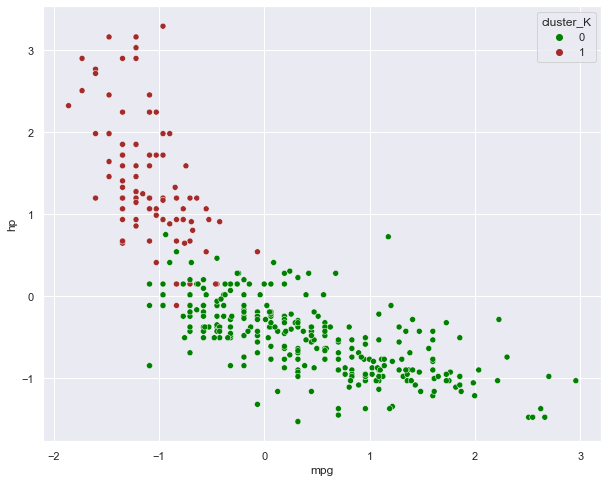

In [68]:
#plotting the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x="mpg", y="hp", hue="cluster_K",
              data=cc_z1, 
                    palette=['green','brown']);

In [69]:
carH.clusters_H.value_counts().sort_index()

1    100
2    298
Name: clusters_H, dtype: int64

In [70]:
carK.cluster_K.value_counts().sort_index()

0    293
1    105
Name: cluster_K, dtype: int64

In [71]:
carH.shape

(398, 14)

In [72]:
carK.shape

(398, 14)

In [73]:
car.head()

cyl  yr   mpg   disp     hp    wt   acc  origin_america  origin_asia  \
0    8  70  18.0  307.0  130.0  3504  12.0               1            0   
1    8  70  15.0  350.0  165.0  3693  11.5               1            0   
2    8  70  18.0  318.0  150.0  3436  11.0               1            0   
3    8  70  16.0  304.0  150.0  3433  12.0               1            0   
4    8  70  17.0  302.0  140.0  3449  10.5               1            0   

   origin_europe  mpg_level_high  mpg_level_low  mpg_level_medium  
0              0               0              0                 1  
1              0               0              1                 0  
2              0               0              0                 1  
3              0               0              1                 0  
4              0               0              0                 1

# 5. Answer below questions based on outcomes of using ML based methods.

#### • Mention how many optimal clusters are present in the data and what could be the possible reason behind it.
    As per the K-Means Clustering, Heirarchical Clustering and Elbow Method we can see 2 optimal clusters in the data

## Linear regression on the original dataset

In [74]:
X = car.drop(['mpg','origin_europe','mpg_level_low'], axis=1)
# the dependent variable
y = car[['mpg']]

In [75]:
# Split X and y into training and test set in 70:30 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=15)

In [76]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

In [77]:
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is: {}".format(col_name, regression_model.coef_[0][idx]))

The coefficient for cyl is: -0.5134441386218929
The coefficient for yr is: 0.44346504291168326
The coefficient for disp is: 0.010688858394647005
The coefficient for hp is: 0.010315514536313984
The coefficient for wt is: -0.004538788568737149
The coefficient for acc is: 0.19183425608862584
The coefficient for origin_america is: -1.7306209513689026
The coefficient for origin_asia is: -0.8976724344009384
The coefficient for mpg_level_high is: 8.55237466381703
The coefficient for mpg_level_medium is: 1.5941218694850463


In [78]:
intercept = regression_model.intercept_[0]
print("The intercept for our model is: {}".format(intercept))

The intercept for our model is: -1.6635717568650534


In [79]:
regression_model.score(X_train, y_train)

0.8967703023839786

In [80]:
O=regression_model.score(X_test, y_test)
O

0.9037421476349176

## Linear regression on data with K means cluster

In [81]:
#renaming the cluster labels to light and heavy vehicles and creating dummy variables of it
carK['cluster_K']=carK['cluster_K'].astype('category')
carK['cluster_K'] = carK['cluster_K'].replace({1: 'heavy', 0: 'light'})
carK = pd.get_dummies(carK, columns=['cluster_K'])

In [82]:
carK.head()

cyl  yr   mpg   disp     hp    wt   acc  origin_america  origin_asia  \
0    8  70  18.0  307.0  130.0  3504  12.0               1            0   
1    8  70  15.0  350.0  165.0  3693  11.5               1            0   
2    8  70  18.0  318.0  150.0  3436  11.0               1            0   
3    8  70  16.0  304.0  150.0  3433  12.0               1            0   
4    8  70  17.0  302.0  140.0  3449  10.5               1            0   

   origin_europe  mpg_level_high  mpg_level_low  mpg_level_medium  \
0              0               0              0                 1   
1              0               0              1                 0   
2              0               0              0                 1   
3              0               0              1                 0   
4              0               0              0                 1   

   cluster_K_heavy  cluster_K_light  
0                1                0  
1                1                0  
2                1                0  
3                1                0  
4                1                0

In [83]:
X = carK.drop(['mpg','origin_europe','mpg_level_low','cluster_K_light'], axis=1)
# the dependent variable
y = carK[['mpg']]

In [84]:
X.head()

cyl  yr   disp     hp    wt   acc  origin_america  origin_asia  \
0    8  70  307.0  130.0  3504  12.0               1            0   
1    8  70  350.0  165.0  3693  11.5               1            0   
2    8  70  318.0  150.0  3436  11.0               1            0   
3    8  70  304.0  150.0  3433  12.0               1            0   
4    8  70  302.0  140.0  3449  10.5               1            0   

   mpg_level_high  mpg_level_medium  cluster_K_heavy  
0               0                 1                1  
1               0                 0                1  
2               0                 1                1  
3               0                 0                1  
4               0                 1                1

In [85]:
# Split X and y into training and test set in 70:30 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=12)

In [86]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

In [87]:
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is: {}".format(col_name, regression_model.coef_[0][idx]))

The coefficient for cyl is: -1.1945995644777512
The coefficient for yr is: 0.43186510415059765
The coefficient for disp is: 0.01747749627910991
The coefficient for hp is: -0.010138045835905822
The coefficient for wt is: -0.004068430169386408
The coefficient for acc is: 0.1856482874625017
The coefficient for origin_america is: -1.6918315494304048
The coefficient for origin_asia is: -0.740777919230302
The coefficient for mpg_level_high is: 9.28312093915688
The coefficient for mpg_level_medium is: 2.250001714231251
The coefficient for cluster_K_heavy is: 2.5115140143384744


In [88]:
intercept = regression_model.intercept_[0]
print("The intercept for our model is: {}".format(intercept))

The intercept for our model is: 1.2041468067172296


In [89]:
regression_model.score(X_train, y_train)

0.8942370456543636

In [90]:
K=regression_model.score(X_test, y_test)
K

0.9117893808052381

## Linear regression on data with H-clusters

In [91]:
#renaming the cluster labels to light and heavy vehicles and creating summy variable of it
carH['clusters_H']=carH['clusters_H'].astype('category')
carH['clusters_H'] = carH['clusters_H'].replace({1: 'heavy', 2: 'light'})
carH = pd.get_dummies(carH, columns=['clusters_H'])

In [92]:
X = carH.drop(['mpg','origin_europe','mpg_level_low','clusters_H_light'], axis=1)
# the dependent variable
y = carH[['mpg']]

In [93]:
# Split X and y into training and test set in 70:30 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=10)

In [94]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

In [95]:
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is: {}".format(col_name, regression_model.coef_[0][idx]))

The coefficient for cyl is: -1.0104832432575337
The coefficient for yr is: 0.4475417357550159
The coefficient for disp is: 0.01511520052461449
The coefficient for hp is: -0.013301584387234262
The coefficient for wt is: -0.0042641797806725655
The coefficient for acc is: 0.11805139164484654
The coefficient for origin_america is: -2.1174569315391114
The coefficient for origin_asia is: -1.3974915348558097
The coefficient for mpg_level_high is: 8.565948239298276
The coefficient for mpg_level_medium is: 1.6577250698582757
The coefficient for clusters_H_heavy is: 2.03897446880741


In [96]:
intercept = regression_model.intercept_[0]
print("The intercept for our model is {}".format(intercept))

The intercept for our model is 2.5727293182325965


In [97]:
regression_model.score(X_train, y_train)

0.8988409890950728

In [98]:
H=regression_model.score(X_test, y_test)
H

0.901023837384672

In [99]:
modellists = []
modellists.append(['Linear Regression on Original Data set', O*100])
modellists.append(['Linear Regression with K means clusters', K*100])
modellists.append(['Linear Regression with Heirarchical clusters', H*100])
mdl_df = pd.DataFrame(modellists, columns = ['Model','r^2 on Test'])
mdl_df

Model  r^2 on Test
0        Linear Regression on Original Data set    90.374215
1       Linear Regression with K means clusters    91.178938
2  Linear Regression with Heirarchical clusters    90.102384

# Summary:
    K-means appears to explain the highest variation in the datset, but with a difference of only 1% when compared with 
    other models, to get more clarity a larger dataset may be used, since this is a dataset of used cars it doesn't give 
    us how many previous owners has the cars seen which might be helful variable, the gender of the previous owners, the
    reason/purpose that the cars were being used is also an important factor which the dataset doen't capture. With the 
    above mentioned features it may be possible to get a higher accuracy or explainability of the models and its variables.

# 6. Improvisation:

- Detailed suggestions or improvements or on quality, quantity, variety, velocity, veracity etc. on the data points collected by the company to perform a better data analysis in future.
- The volume of the data is 398. If we have more volume, we can train the model with best accracy and the performance will be good. Velocity is meant for real time or active data. Here, we used only static data
- Data veracity is the degree to which data is accurate, precise and trusted. Data is often viewed as certain and reliable. More data leads to more accurate.
- The company would have collected atleast 1000 instances to perform the model

## 

# PART II

## DOMAIN: 
Manufacturing
### CONTEXT: 
Company X curates and packages wine across various vineyards spread throughout the country.
### DATA DESCRIPTION: 
The data concerns the chemical composition of the wine and its respective quality.
### Attribute Information:
1. A, B, C, D: specific chemical composition measure of the wine
2. Quality: quality of wine [ Low and High ]

### PROJECT OBJECTIVE: 
Goal is to build a synthetic data generation model using the existing data provided by the company.

# 1. Design a synthetic data generation model which can impute values [Attribute: Quality] wherever empty the company has missed recording the data.

In [100]:
#Loading the required packages
import numpy as np   
import pandas as pd    
import matplotlib.pyplot as plt 
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import seaborn as sns
%matplotlib inline 
sns.set(color_codes=True)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [101]:
#importing the data
import xlrd
wi=pd.read_excel('Part2 - Company.xlsx')
wi.head()

A    B    C    D    Quality
0   47   27   45  108  Quality A
1  174  133  134  166  Quality B
2  159  163  135  131        NaN
3   61   23    3   44  Quality A
4   59   60    9   68  Quality A

In [102]:
row, column = wi.shape
print('The dataset contains', row, 'rows and', column, 'columns')

The dataset contains 61 rows and 5 columns


In [103]:
print(wi.shape)
print(wi.size)

(61, 5)
305


In [104]:
#make a copy of the data
wi1=wi.copy()

In [105]:
#dropping the target variable
wi=wi.drop('Quality',axis=1)

In [106]:
#checking for data types
print('The data type of each attribute: \n')
wi1.info()

The data type of each attribute: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   A        61 non-null     int64 
 1   B        61 non-null     int64 
 2   C        61 non-null     int64 
 3   D        61 non-null     int64 
 4   Quality  43 non-null     object
dtypes: int64(4), object(1)
memory usage: 2.5+ KB


In [107]:
print('The Target Variable has set 18 missing values \n')
wi1.isnull().sum()

The Target Variable has set 18 missing values 



A           0
B           0
C           0
D           0
Quality    18
dtype: int64

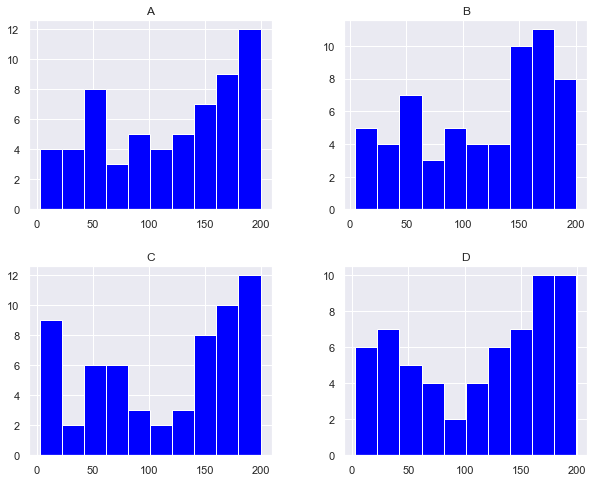

In [108]:
#checking the distribution of the data points
wi.hist(bins = 10, figsize = (10, 8), color = 'blue')
plt.show()

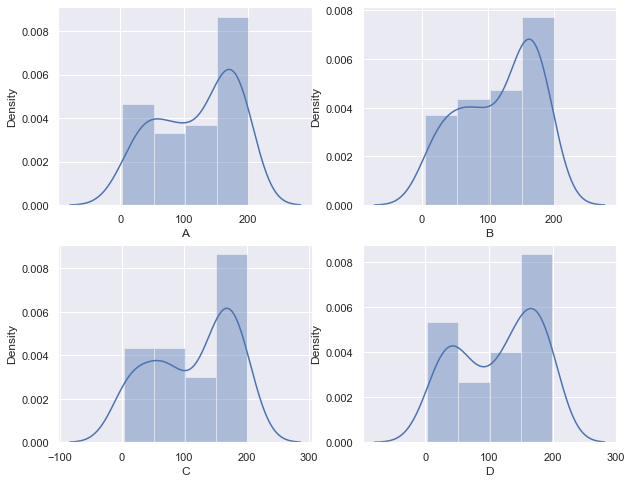

In [109]:
#checking for the density of the variable
plt.figure(figsize=(10, 8))
col = 1
for i in wi.columns:
    plt.subplot(2, 2, col)
    sns.distplot(wi[i], color = 'b')
    col += 1 

**The chemical compositions are on the same scales between 0 to 200**

In [110]:
#scaling the numeric variables
w1 = wi.apply(zscore)
w1.head()

A         B         C         D
0 -1.168034 -1.561080 -1.061569 -0.103138
1  0.904992  0.284923  0.306077  0.823013
2  0.660147  0.807376  0.321443  0.264129
3 -0.939512 -1.630740 -1.706975 -1.125099
4 -0.972158 -0.986381 -1.614775 -0.741864

In [111]:
#checking for the distribution of the targrt variables
wi1['Quality'].value_counts()

Quality A    26
Quality B    17
Name: Quality, dtype: int64

In [112]:
#applying kmeans with 2 centroids
k_means = KMeans(n_clusters = 2)
k_means.fit(w1)
labels = k_means.labels_

In [113]:
# Calculating silhouette_score
silhouette_score(w1,labels)

0.6891674125195145

In [114]:
#attaching the cluster labels to the original dataset
wi1["Quality_k"] = labels

In [115]:
#checking for the first 15 observations
wi1.head(15)

A    B    C    D    Quality  Quality_k
0    47   27   45  108  Quality A          1
1   174  133  134  166  Quality B          0
2   159  163  135  131        NaN          0
3    61   23    3   44  Quality A          1
4    59   60    9   68  Quality A          1
5   153  140  154  199        NaN          0
6    34   28   78   22  Quality A          1
7   191  144  143  154        NaN          0
8   160  181  194  178  Quality B          0
9   145  178  158  141        NaN          0
10   76   94  107   37  Quality A          1
11  138  200  153  192  Quality B          0
12   27  106   57   37  Quality A          1
13   45   76   56   57  Quality A          1
14  186  142  146  174        NaN          0

In [116]:
#renaming the cluster labels
wi1['Quality_k'] = wi1['Quality_k'].replace({0: 'Quality A', 1: 'Quality B'})

In [117]:
#checking for datatypes
wi1.dtypes

A             int64
B             int64
C             int64
D             int64
Quality      object
Quality_k    object
dtype: object

In [118]:
#dropping na rows
wn=wi1.dropna()

In [119]:
#checking for the shape
wn.shape

(43, 6)

In [120]:
#using the cluster labels and actual target labels to check for accuracy
pred = wn['Quality_k']
actual = wn['Quality']

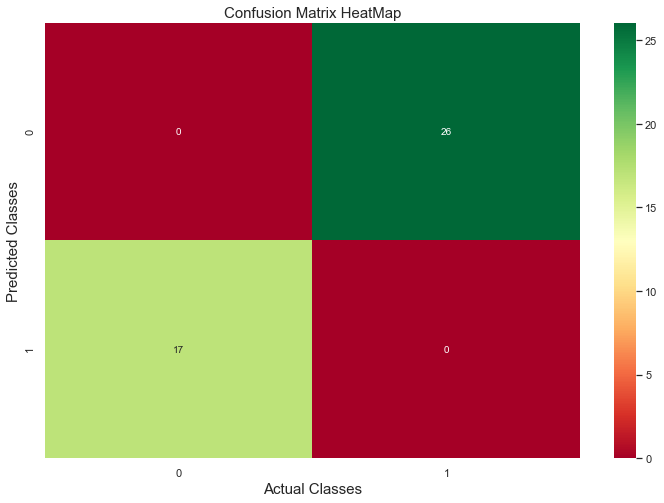

In [121]:
#visualization of confusion matrix in the form of a heatmap
cm= confusion_matrix(actual, pred)
plt.figure(figsize = (12, 8))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.xlabel('Actual Classes', fontsize = 15)
plt.ylabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix HeatMap', fontsize = 15);

   **There appears to be no misclassification when checking it with the non missing target variables and the predicted clusters, Hence the new labels can be used as a target variable**

## 

# PART III

### DOMAIN: Automobile
### CONTEXT: 
The purpose is to classify a given silhouette as one of three types of vehicle, using a set of features extracted from the silhouette.
The vehicle may be viewed from one of many different angles.
### DATA DESCRIPTION: 
The data contains features extracted from the silhouette of vehicles in different angles. Four "Corgie" model vehicles
were used for the experiment: a double decker bus, Cheverolet van, Saab 9000 and an Opel Manta 400 cars. This particular combination of
vehicles was chosen with the expectation that the bus, van and either one of the cars would be readily distinguishable, but it would be more
difficult to distinguish between the cars.
• All the features are numeric i.e. geometric features extracted from the silhouette.
### PROJECT OBJECTIVE: 
Apply dimensionality reduction technique – PCA and train a model using principal components instead of training the
model using just the raw data.

In [122]:
#Loading the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn import metrics
%matplotlib inline
sns.set(color_codes=True)
import warnings
warnings.filterwarnings('ignore')

# 1. Data: 
**Import, clean and pre-process the data**

In [123]:
#import the dataset
ve = pd.read_csv('Part3 - vehicle.csv')
ve.head()

compactness  circularity  distance_circularity  radius_ratio  \
0           95         48.0                  83.0         178.0   
1           91         41.0                  84.0         141.0   
2          104         50.0                 106.0         209.0   
3           93         41.0                  82.0         159.0   
4           85         44.0                  70.0         205.0   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0                  72.0                       10          162.0   
1                  57.0                        9          149.0   
2                  66.0                       10          207.0   
3                  63.0                        9          144.0   
4                 103.0                       52          149.0   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0           42.0                    20.0                        159   
1           45.0                    19.0                        143   
2           32.0                    23.0                        158   
3           46.0                    19.0                        143   
4           45.0                    19.0                        144   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0            176.0              379.0                      184.0   
1            170.0              330.0                      158.0   
2            223.0              635.0                      220.0   
3            160.0              309.0                      127.0   
4            241.0              325.0                      188.0   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                         70.0             6.0              16.0   
1                         72.0             9.0              14.0   
2                         73.0            14.0               9.0   
3                         63.0             6.0              10.0   
4                        127.0             9.0              11.0   

   skewness_about.2  hollows_ratio class  
0             187.0            197   van  
1             189.0            199   van  
2             188.0            196   car  
3             199.0            207   van  
4             180.0            183   bus

In [124]:
print(ve.shape)

(846, 19)


In [125]:
#checking for the dimension of the data
rows, column = ve.shape
print('The dataset contains', rows, 'rows and', column, 'columns.')

The dataset contains 846 rows and 19 columns.


In [126]:
#checking for the data type
print('The data type of each attribute: \n')
ve.info()

The data type of each attribute: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   compactness                  846 non-null    int64  
 1   circularity                  841 non-null    float64
 2   distance_circularity         842 non-null    float64
 3   radius_ratio                 840 non-null    float64
 4   pr.axis_aspect_ratio         844 non-null    float64
 5   max.length_aspect_ratio      846 non-null    int64  
 6   scatter_ratio                845 non-null    float64
 7   elongatedness                845 non-null    float64
 8   pr.axis_rectangularity       843 non-null    float64
 9   max.length_rectangularity    846 non-null    int64  
 10  scaled_variance              843 non-null    float64
 11  scaled_variance.1            844 non-null    float64
 12  scaled_radius_of_gyration    844 non-null  

In [127]:
print('Duplicated rows: ', ve[ve.duplicated()].shape[0])

Duplicated rows:  0


In [128]:
print('Null values:\n\n', ve.isnull().sum())

Null values:

 compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64


**There appears to be quite a few missing values**

In [129]:
#replacing the missing values with median values
for cols in ve.columns:
    if(cols != 'class'): 
        ve[cols] = ve[cols].fillna(ve[cols].median())

In [130]:
ve.isnull().sum()

compactness                    0
circularity                    0
distance_circularity           0
radius_ratio                   0
pr.axis_aspect_ratio           0
max.length_aspect_ratio        0
scatter_ratio                  0
elongatedness                  0
pr.axis_rectangularity         0
max.length_rectangularity      0
scaled_variance                0
scaled_variance.1              0
scaled_radius_of_gyration      0
scaled_radius_of_gyration.1    0
skewness_about                 0
skewness_about.1               0
skewness_about.2               0
hollows_ratio                  0
class                          0
dtype: int64

In [131]:
#5-point summary
ve.describe().T

count        mean         std    min     25%  \
compactness                  846.0   93.678487    8.234474   73.0   87.00   
circularity                  846.0   44.823877    6.134272   33.0   40.00   
distance_circularity         846.0   82.100473   15.741569   40.0   70.00   
radius_ratio                 846.0  168.874704   33.401356  104.0  141.00   
pr.axis_aspect_ratio         846.0   61.677305    7.882188   47.0   57.00   
max.length_aspect_ratio      846.0    8.567376    4.601217    2.0    7.00   
scatter_ratio                846.0  168.887707   33.197710  112.0  147.00   
elongatedness                846.0   40.936170    7.811882   26.0   33.00   
pr.axis_rectangularity       846.0   20.580378    2.588558   17.0   19.00   
max.length_rectangularity    846.0  147.998818   14.515652  118.0  137.00   
scaled_variance              846.0  188.596927   31.360427  130.0  167.00   
scaled_variance.1            846.0  439.314421  176.496341  184.0  318.25   
scaled_radius_of_gyration    846.0  174.706856   32.546277  109.0  149.00   
scaled_radius_of_gyration.1  846.0   72.443262    7.468734   59.0   67.00   
skewness_about               846.0    6.361702    4.903244    0.0    2.00   
skewness_about.1             846.0   12.600473    8.930962    0.0    5.00   
skewness_about.2             846.0  188.918440    6.152247  176.0  184.00   
hollows_ratio                846.0  195.632388    7.438797  181.0  190.25   

                               50%     75%     max  
compactness                   93.0  100.00   119.0  
circularity                   44.0   49.00    59.0  
distance_circularity          80.0   98.00   112.0  
radius_ratio                 167.0  195.00   333.0  
pr.axis_aspect_ratio          61.0   65.00   138.0  
max.length_aspect_ratio        8.0   10.00    55.0  
scatter_ratio                157.0  198.00   265.0  
elongatedness                 43.0   46.00    61.0  
pr.axis_rectangularity        20.0   23.00    29.0  
max.length_rectangularity    146.0  159.00   188.0  
scaled_variance              179.0  217.00   320.0  
scaled_variance.1            363.5  586.75  1018.0  
scaled_radius_of_gyration    173.5  198.00   268.0  
scaled_radius_of_gyration.1   71.5   75.00   135.0  
skewness_about                 6.0    9.00    22.0  
skewness_about.1              11.0   19.00    41.0  
skewness_about.2             188.0  193.00   206.0  
hollows_ratio                197.0  201.00   211.0

# 2. EDA and visualisation:

### Create a detailed performance report using univariate, bi-variate and multivariate EDA techniques. Find out all possible hidden patterns by using all possible methods.

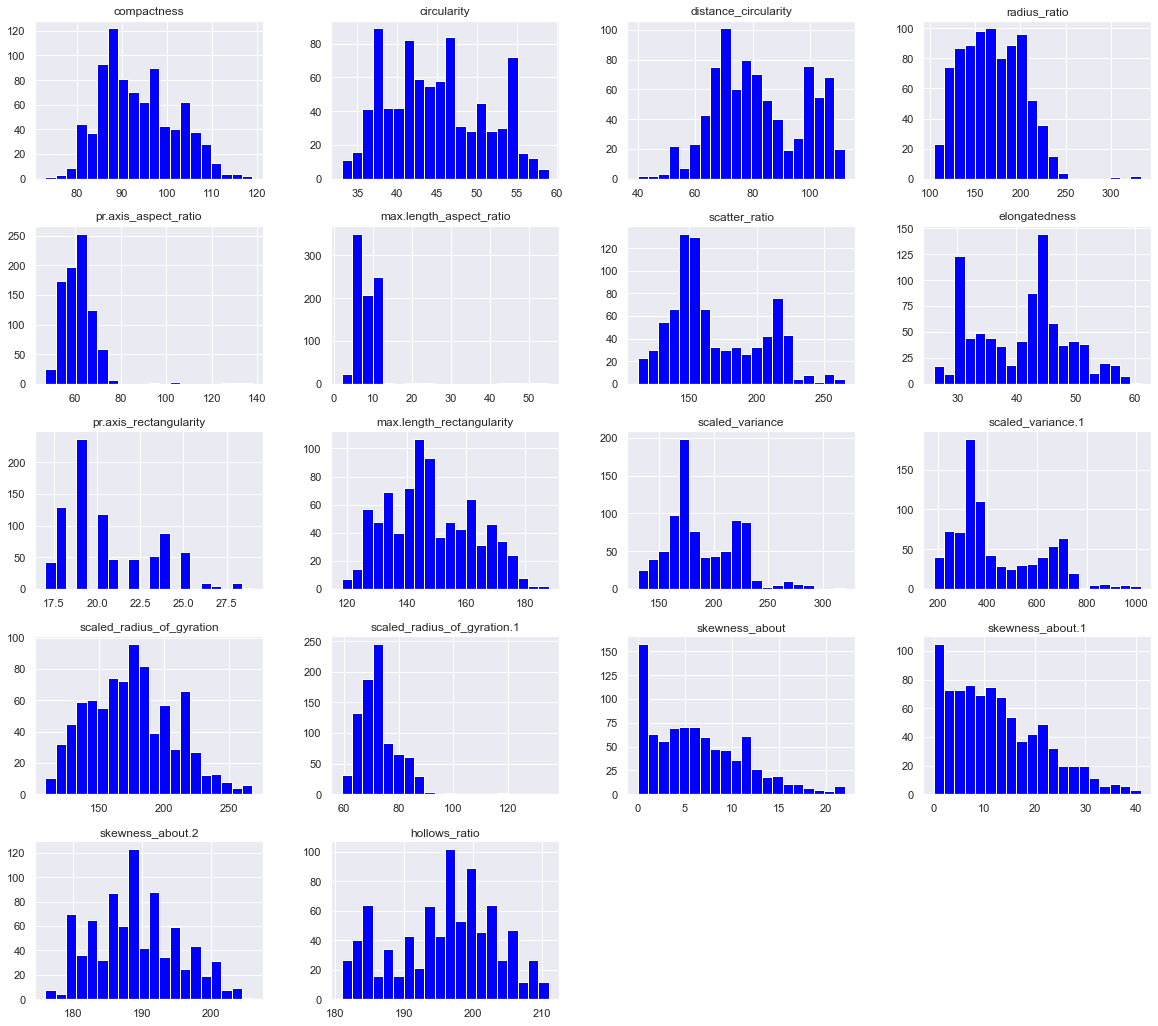

In [132]:
#plotting the distribution of the numerical variables
ve.hist(bins = 20, figsize = (20, 18), color = 'blue')
plt.show()

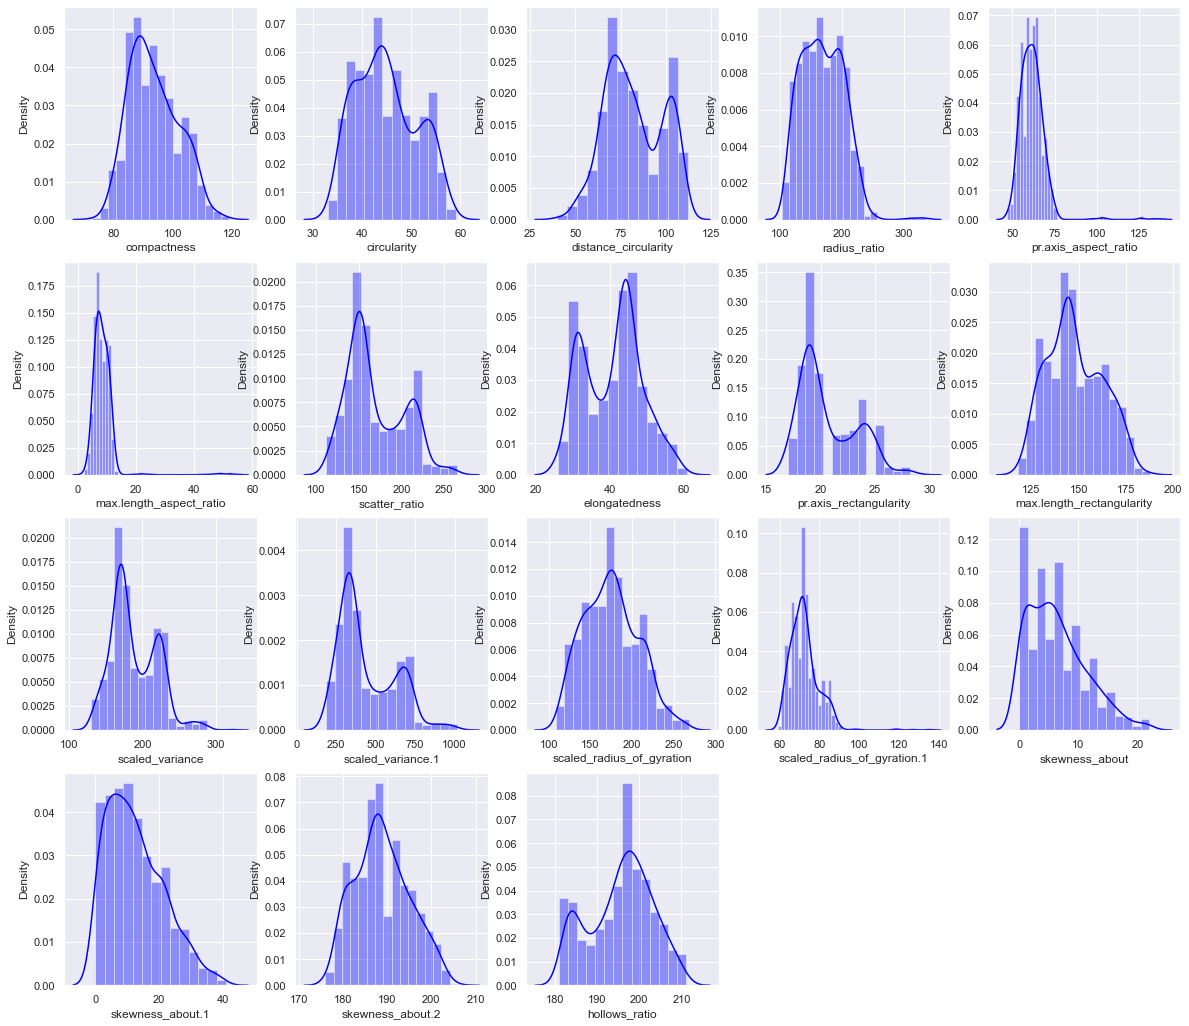

In [133]:
#Density plots
plt.figure(figsize=(20, 18))
col = 1
for i in ve.drop(columns='class').columns:
    plt.subplot(4, 5, col)
    sns.distplot(ve[i], color = 'blue')
    col += 1 

- Columns have data distributed across multiple scales.
- Several columns have distributions that are not unimodal (eg.: distance_circularity, hollows_ratio, elongatedness Column.
- skweness_about, skewness_about.1 have data that is right skewed whereas for column skewness_about.2 data is nearly normally 
     distributed.
- Some columns have long right tail (eg.: pr.axis_aspect_ratio) as evident from the above distplot it is highly likely that 
     they will have outliers.

car    429
bus    218
van    199
Name: class, dtype: int64


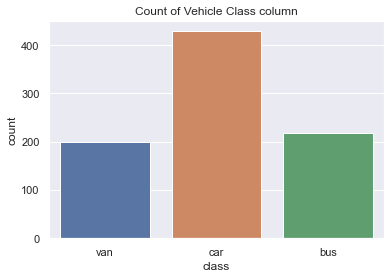

In [134]:
#checking the distribution of the class variable
print(ve['class'].value_counts())
plt.title('Count of Vehicle Class column')
sns.countplot(x = 'class', data = ve);

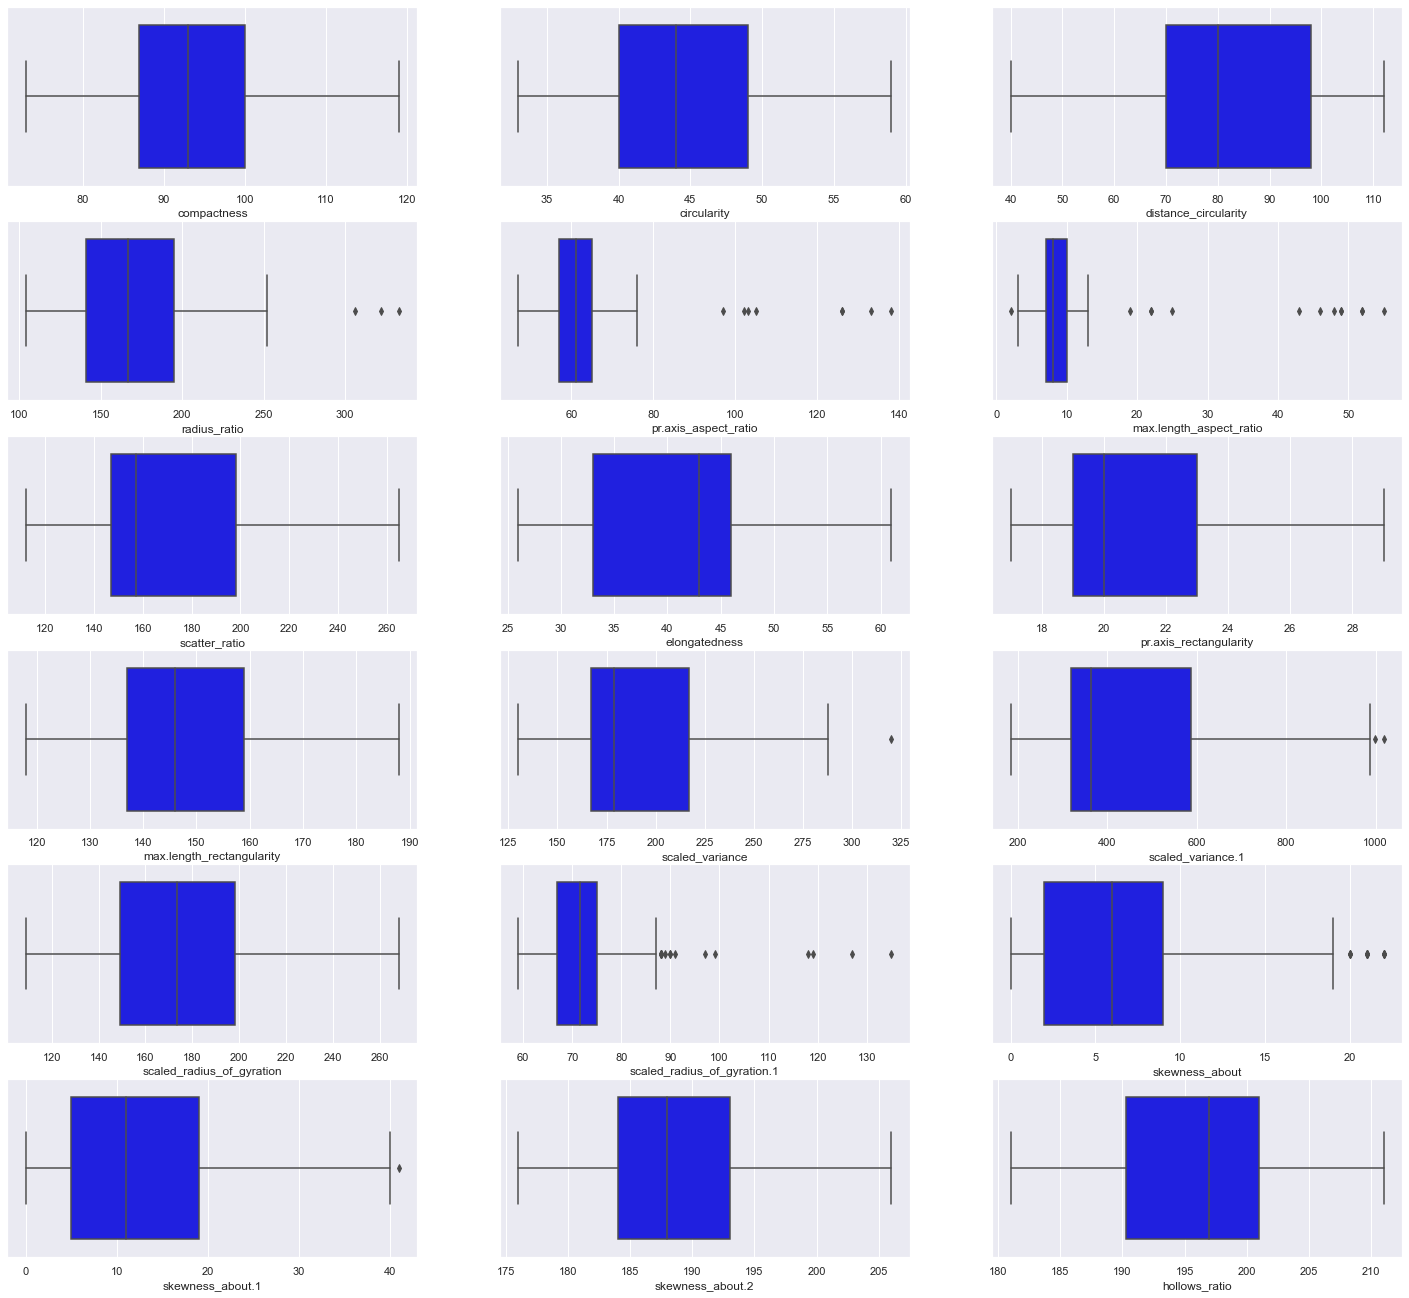

In [135]:
#boxplots for outliers
plt.figure(figsize=(25,23))
col = 1
for i in ve.drop(columns='class').columns:
    plt.subplot(6, 3, col)
    sns.boxplot(ve[i],color='blue')
    col += 1

**Above Boxplots reveal that there are outliers in 8 different columns., will have them treated eventually**

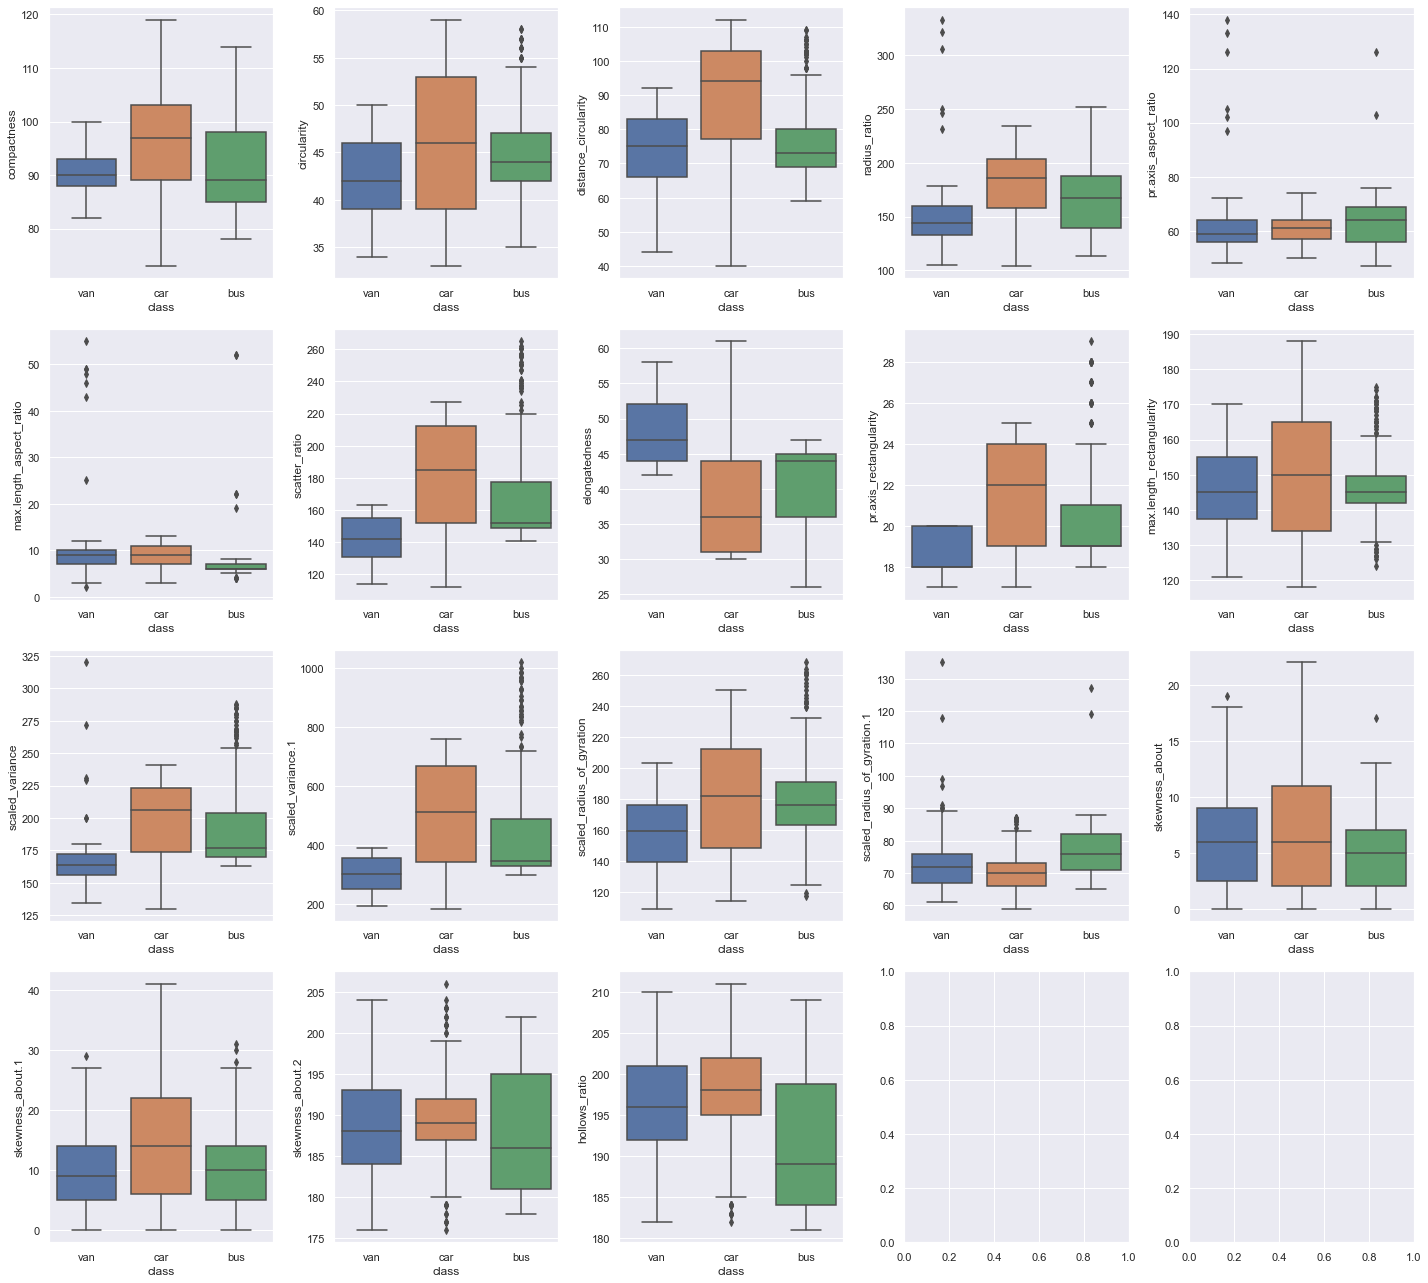

In [136]:
#Boxplots against the class with other numeric variables
fig,axs = plt.subplots(4,5,figsize=(20,18))
sns.boxplot(x="class", y="compactness",data=ve,ax=axs[0,0]);
sns.boxplot(x="class", y="circularity",data=ve,ax=axs[0,1]);
sns.boxplot(x="class", y="distance_circularity",data=ve,ax=axs[0,2]);
sns.boxplot(x="class", y="radius_ratio",data=ve,ax=axs[0,3]);
sns.boxplot(x="class", y="pr.axis_aspect_ratio",data=ve,ax=axs[0,4]);
sns.boxplot(x="class", y="max.length_aspect_ratio",data=ve,ax=axs[1,0]);
sns.boxplot(x="class", y="scatter_ratio",data=ve,ax=axs[1,1]);
sns.boxplot(x="class", y="elongatedness",data=ve,ax=axs[1,2]);
sns.boxplot(x="class", y="pr.axis_rectangularity",data=ve,ax=axs[1,3]);
sns.boxplot(x="class", y="max.length_rectangularity",data=ve,ax=axs[1,4]);
sns.boxplot(x="class", y="scaled_variance",data=ve,ax=axs[2,0]);
sns.boxplot(x="class", y="scaled_variance.1",data=ve,ax=axs[2,1]);
sns.boxplot(x="class", y="scaled_radius_of_gyration",data=ve,ax=axs[2,2]);
sns.boxplot(x="class", y="scaled_radius_of_gyration.1",data=ve,ax=axs[2,3]);
sns.boxplot(x="class", y="skewness_about",data=ve,ax=axs[2,4]);
sns.boxplot(x="class", y="skewness_about.1",data=ve,ax=axs[3,0]);
sns.boxplot(x="class", y="skewness_about.2",data=ve,ax=axs[3,1]);
sns.boxplot(x="class", y="hollows_ratio",data=ve,ax=axs[3,2]);
fig.tight_layout()

**There is significant difference between classes when compared with the mean and median with all the numeric attributes**

In [137]:
#find the outliers and replace them by median
for col_name in ve.drop(columns = 'class').columns:
    q1 = ve[col_name].quantile(0.25)
    q3 = ve[col_name].quantile(0.75)
    iqr = q3 - q1
    
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    
    ve.loc[(ve[col_name] < low) | (ve[col_name] > high), col_name] = ve[col_name].median()

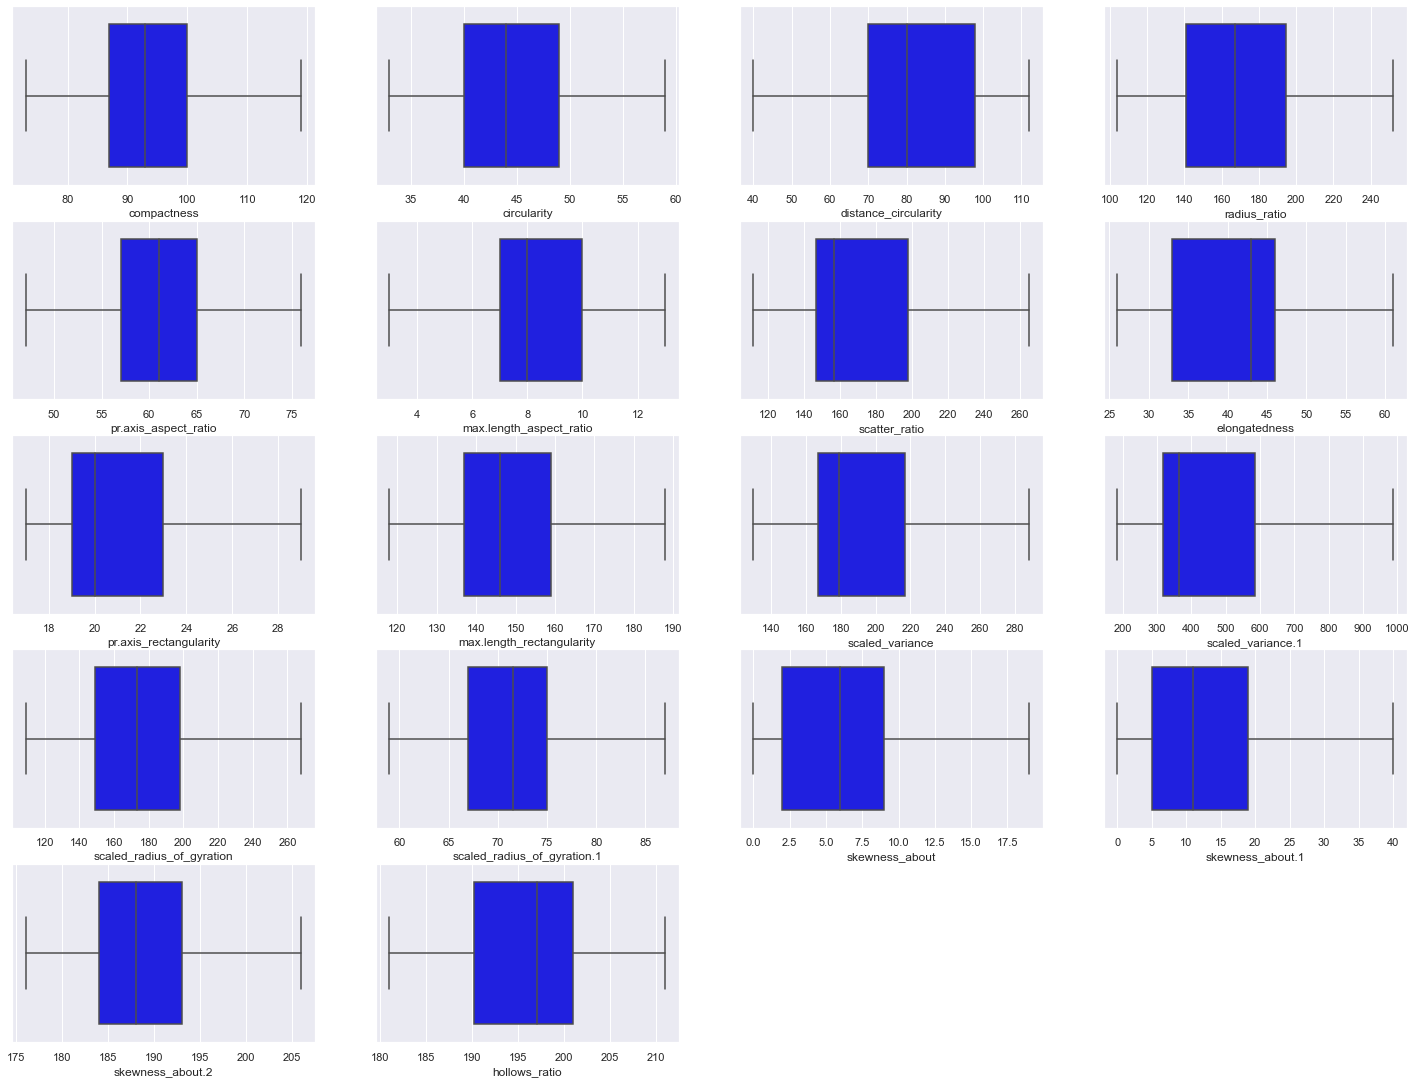

In [138]:
#boxplot after outlier treatment
plt.figure(figsize=(25,23))
col = 1
for i in ve.drop(columns='class').columns:
    plt.subplot(6, 4, col)
    sns.boxplot(ve[i],color='blue')
    col += 1

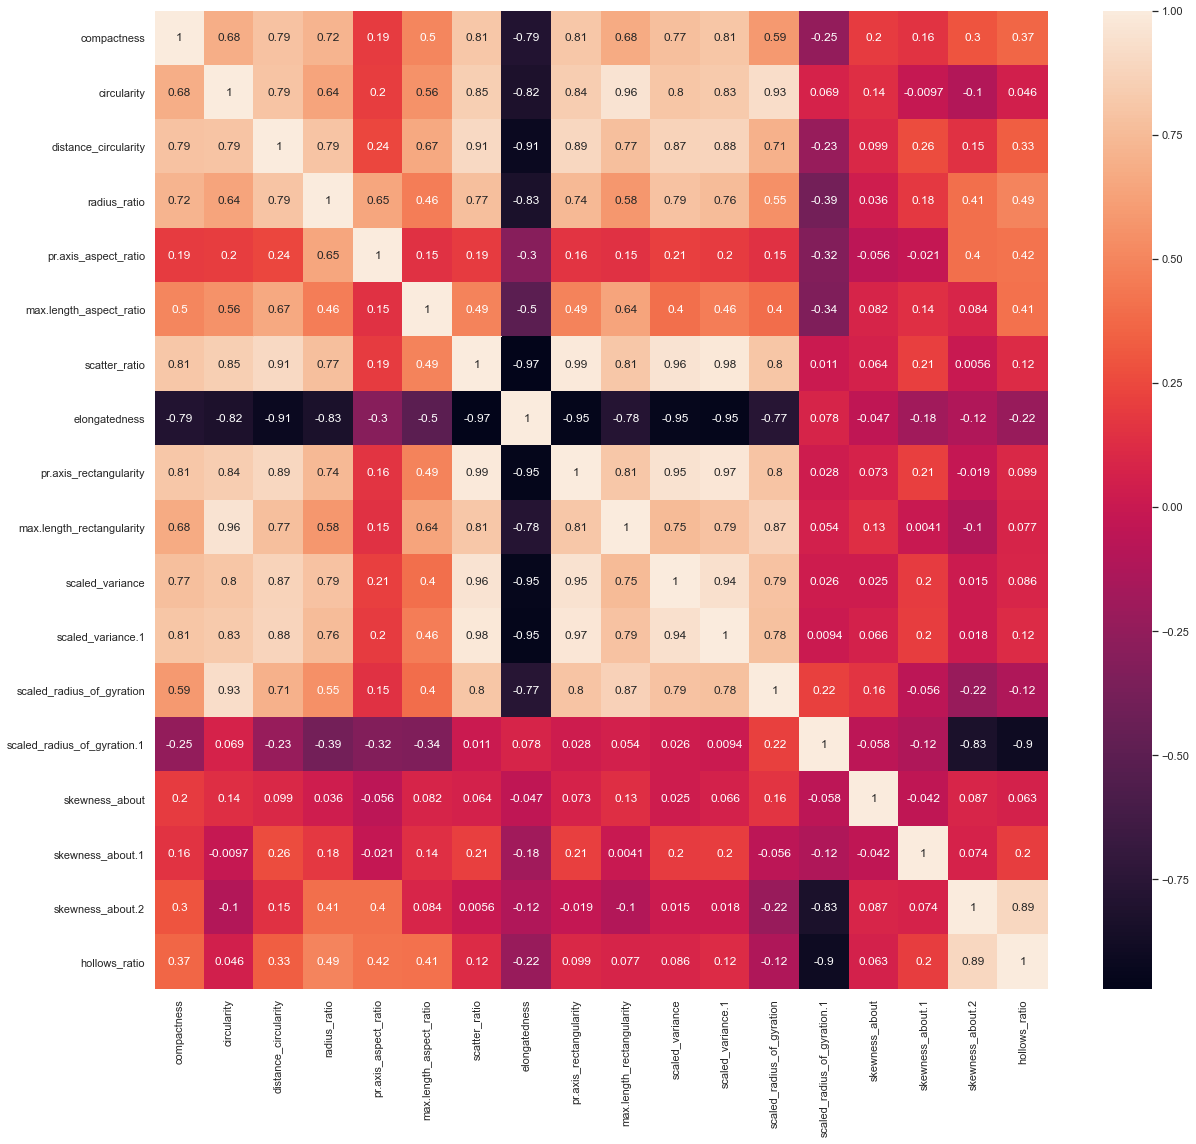

In [139]:
#checking for correlation
plt.figure(figsize=(20,18))
corr=ve.corr()
sns.heatmap(corr,annot=True);

In [140]:
#spliiting the data to check for correlation with the class variable
X = ve.loc[:, ve.columns != 'class']
y = ve['class'].astype('category').cat.codes

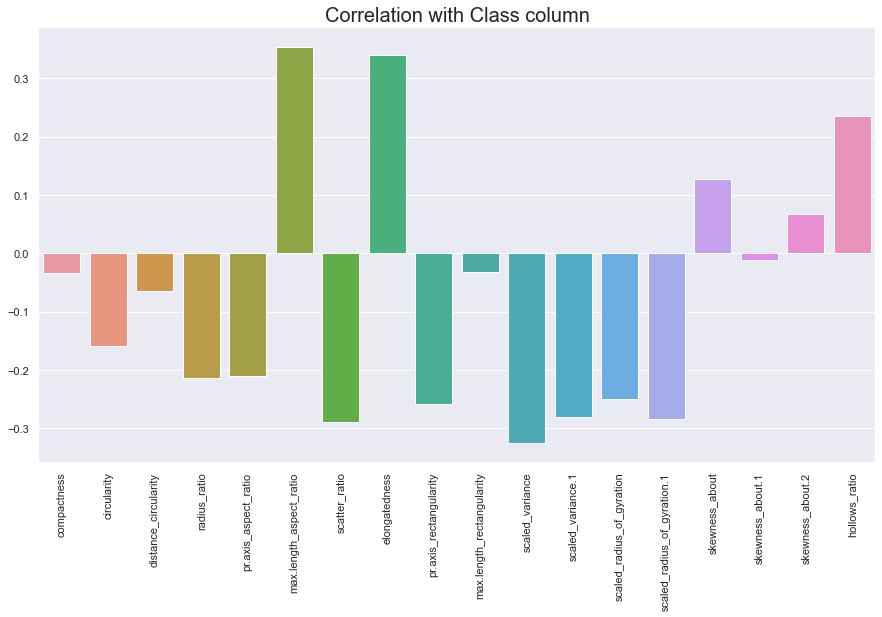

In [141]:
#plotting the correlation with target variable
plt.figure(figsize = (15, 8))
ax=sns.barplot(x=X.columns, y = X.corrwith(y))
sns.barplot(x = X.columns, y = X.corrwith(y))
plt.title('Correlation with Class column', fontsize = 20)
x=plt.setp(ax.get_xticklabels(), rotation=90)

 ### 3. Classifier: Design and train a best fit SVM classier using all the data attributes.

## PCA

In [142]:
#scaling the muerica variables
XScaled=X.apply(zscore)
XScaled.head()

compactness  circularity  distance_circularity  radius_ratio  \
0     0.160580     0.518073              0.057177      0.300945   
1    -0.325470    -0.623732              0.120741     -0.850666   
2     1.254193     0.844303              1.519141      1.265808   
3    -0.082445    -0.623732             -0.006386     -0.290423   
4    -1.054545    -0.134387             -0.769150      1.141310   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0              1.933135                 0.912212      -0.207598   
1             -0.740596                 0.427456      -0.599423   
2              0.863642                 0.912212       1.148719   
3              0.328896                 0.427456      -0.750125   
4             -0.027601                -0.057300      -0.599423   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0       0.136262               -0.224342                   0.758332   
1       0.520519               -0.610886                  -0.344578   
2      -1.144597                0.935290                   0.689401   
3       0.648605               -0.610886                  -0.344578   
4       0.520519               -0.610886                  -0.275646   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0        -0.400771          -0.337407                   0.285705   
1        -0.594220          -0.618623                  -0.513630   
2         1.114582           1.131806                   1.392477   
3        -0.916635          -0.739145                  -1.466683   
4         1.694930          -0.647319                   0.408680   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                    -0.315806       -0.032330          0.387162   
1                     0.009122        0.624090          0.161740   
2                     0.171586        1.718123         -0.401818   
3                    -1.453054       -0.032330         -0.289106   
4                    -0.072110        0.624090         -0.176395   

   skewness_about.2  hollows_ratio  
0         -0.312012       0.183957  
1          0.013265       0.452977  
2         -0.149374       0.049447  
3          1.639649       1.529056  
4         -1.450481      -1.699181

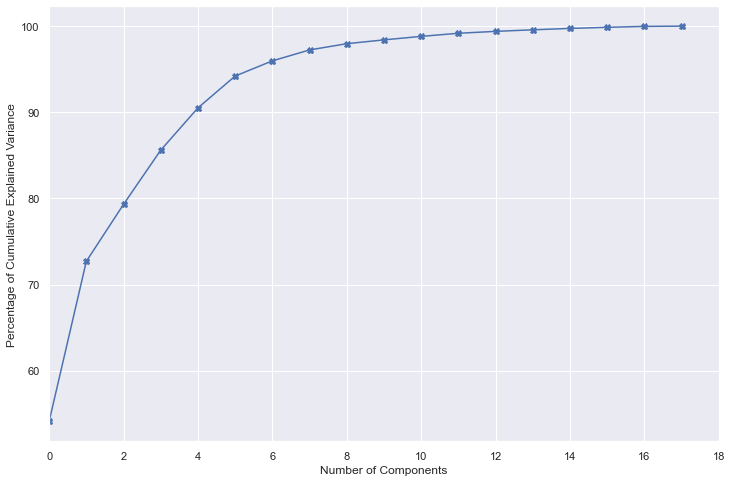

In [143]:
#plotting the cummulative variance explained by the principal componets
pca = PCA()
X_pca_ = pca.fit_transform(XScaled)
plt.figure(figsize = (12, 8))
plt.plot((np.cumsum(pca.explained_variance_ratio_) * 100), marker = 'X')
plt.xlim(0, 18)
plt.xlabel('Number of Components')
plt.ylabel('Percentage of Cumulative Explained Variance');

In [144]:
print(pca.explained_variance_)

[9.74940269e+00 3.35071912e+00 1.19238155e+00 1.13381916e+00
 8.83997312e-01 6.66265745e-01 3.18150910e-01 2.28179142e-01
 1.31018595e-01 7.98619108e-02 7.33979478e-02 6.46162669e-02
 4.01448646e-02 3.22758478e-02 2.93936408e-02 2.27005257e-02
 1.98136761e-02 5.16287320e-03]


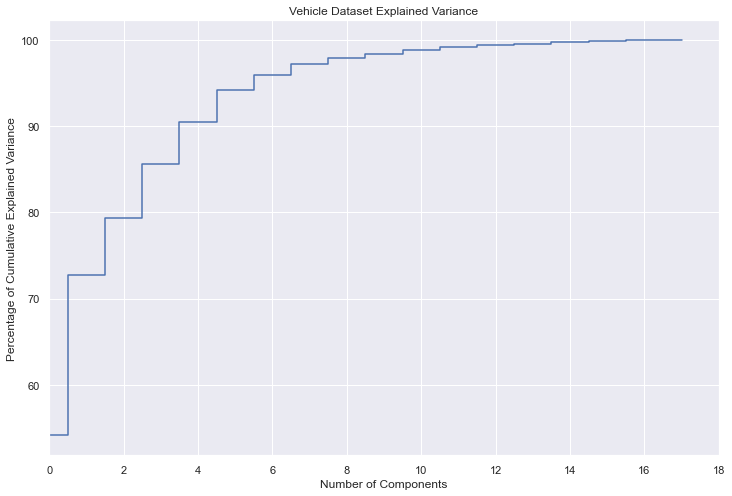

In [145]:
#plotting the cummulative variance explained by the principal componets
plt.figure(figsize = (12, 8))
plt.step(list(range(18)), (np.cumsum(pca.explained_variance_ratio_) * 100), where = 'mid')
plt.xlim(0, 18)
plt.xlabel('Number of Components')
plt.ylabel('Percentage of Cumulative Explained Variance')
plt.title('Vehicle Dataset Explained Variance');

**We can see that the first six components explain more than 95% of variation. Between first 5 components, more than 91% of the information is captured. The above plot shows almost 95% variance by the first 6 components. Therefore we can drop 7th component onwards.**

 ### 4. Dimensional reduction: perform dimensional reduction on the data.

In [146]:
#Using 6 components and printing the eigen vectors
pca3 = PCA(n_components=6)
pca3.fit(XScaled)
print(pca3.components_)
print(pca3.explained_variance_ratio_)
Xpca3 = pca3.transform(XScaled)

[[ 0.27250289  0.28725469  0.30242111  0.26971354  0.09786073  0.19520014
   0.31052393 -0.3090069   0.307287    0.27815416  0.29976509  0.30553237
   0.26323762 -0.04193594  0.03608321  0.05872048  0.03801314  0.08474   ]
 [-0.08704358  0.13162176 -0.04614301 -0.19793126 -0.25783995 -0.10804563
   0.07528535 -0.01322994  0.0875602   0.12215424  0.07726575  0.07150302
   0.21058205  0.50362158 -0.01576632 -0.09274624 -0.50162122 -0.50761211]
 [-0.03818521 -0.20114691  0.06346211  0.05628517 -0.06199275 -0.14895782
   0.10904283 -0.09085269  0.1060705  -0.21368469  0.1445998   0.11034374
  -0.20287019  0.07386402 -0.55917399  0.6706805  -0.06224071 -0.04170535]
 [ 0.13867501 -0.03805548  0.10895429 -0.25435509 -0.61276572  0.27867816
   0.00539295  0.06521486  0.03089915  0.04146747 -0.06400509 -0.00219687
  -0.08553965 -0.11539962  0.47370331  0.42842603 -0.0274096   0.09603749]
 [ 0.13710146 -0.13899555 -0.08001743  0.13374437  0.12360146 -0.63489335
   0.08555745 -0.07907344  0.08164

In [147]:
#printing the original features and the reduced features
pca_6 = PCA(n_components = 6)
X_pca = pca_6.fit_transform(XScaled)
print('Original number of features:', X.shape[1])
print('Reduced number of features:', X_pca.shape[1])

Original number of features: 18
Reduced number of features: 6


In [148]:
#viewing the first 5 observations of the pca components
pca_df = pd.DataFrame(data = X_pca)
pca_df.head()

0         1         2         3         4         5
0  0.584228 -0.675673 -0.453334 -0.750656 -0.777515 -1.848809
1 -1.512180 -0.348934 -0.333436  1.268953 -0.324929 -0.118317
2  3.913448  0.234507 -1.265094  0.137224  0.915751 -0.685594
3 -1.535193 -3.044413 -0.469623  0.324317 -0.611590  0.367777
4 -0.642062  1.488882 -0.246288 -0.550939  0.471655 -1.012697

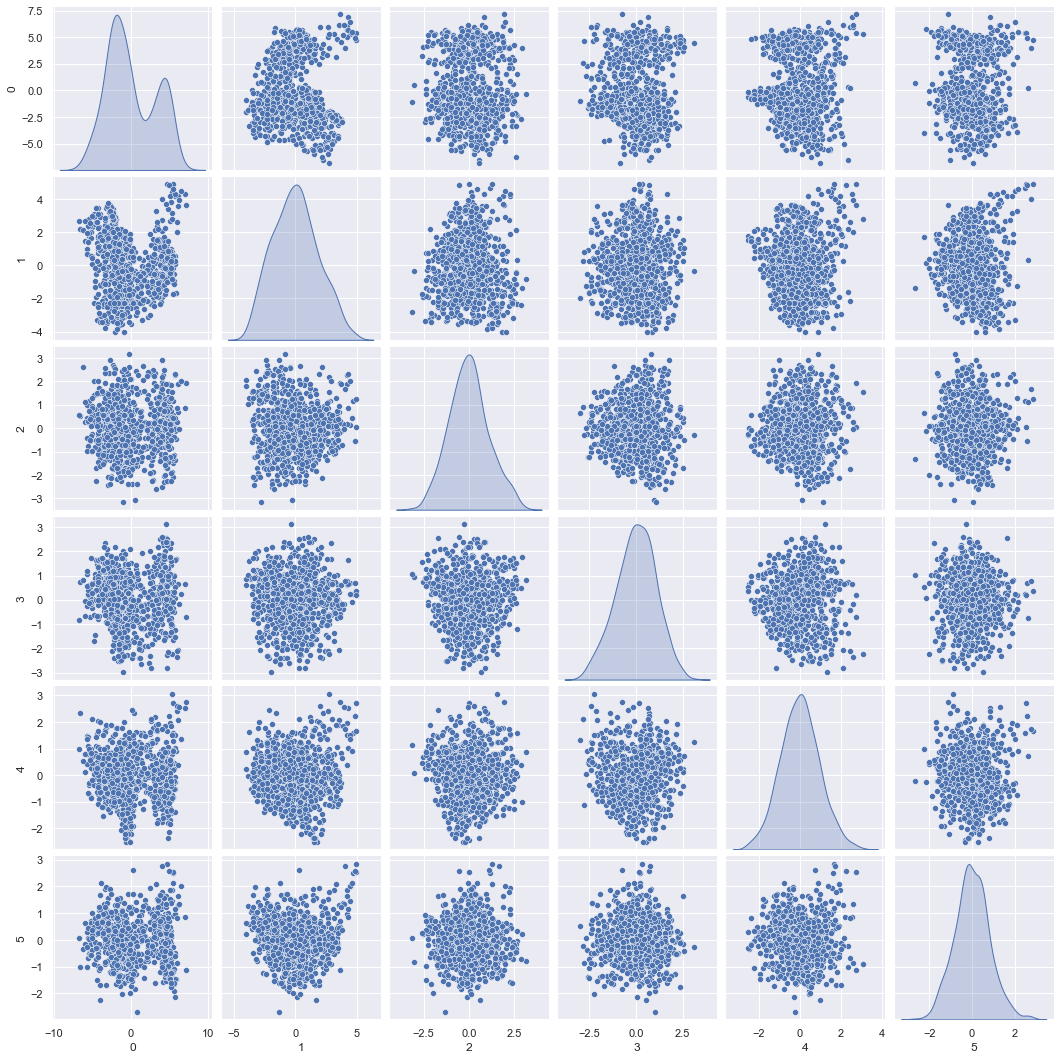

In [149]:
sns.pairplot(pca_df, diag_kind = 'kde');

 ### 5. Classifier: Design and train a best fit SVM classier using dimensionally reduced attributes.

# SVM

In [150]:
#splitting the original data into train and test 70:30
X_train, X_test, y_train, y_test = train_test_split(XScaled, y, test_size = 0.3, random_state = 10)

In [151]:
rtr, ctr = X_train.shape
print('The training set comprises of', rtr, 'rows and', ctr, 'columns.')

The training set comprises of 592 rows and 18 columns.


In [152]:
rt, ct = X_test.shape
print('The test set comprises of', rt, 'rows and', ct, 'columns.')

The test set comprises of 254 rows and 18 columns.


In [153]:
#splitting the pca data into train and test 70:30
X_tr, X_te, y_tr, y_te = train_test_split(X_pca, y, test_size = 0.3, random_state = 10)

In [154]:
rtr_pca, ctr_pca = X_tr.shape
print('The PCA training set comprises of', rtr_pca, 'rows and', ctr_pca, 'columns.')

The PCA training set comprises of 592 rows and 6 columns.


In [155]:
rt_pca, ct_pca = X_te.shape
print('The PCA test set comprises of', rt_pca, 'rows and', ct_pca, 'columns.')

The PCA test set comprises of 254 rows and 6 columns.


In [156]:
# Building a Support Vector Machine on train data
svc_model = SVC(C= 4, kernel='rbf', gamma='scale')
svc_model.fit(X_train, y_train)

SVC(C=4)

In [157]:
#predicting on train data
sv_train_predict = svc_model .predict(X_train)
print("Model Accuracy on train: {0:.4f}".format(metrics.accuracy_score(y_train, sv_train_predict)))
print()

Model Accuracy on train: 0.9899



In [158]:
#predicting on test data
sv_test_predict = svc_model .predict(X_test)
print("Model Accuracy on test: {0:.4f}".format(metrics.accuracy_score(y_test, sv_test_predict)))
print()

Model Accuracy on test: 0.9685



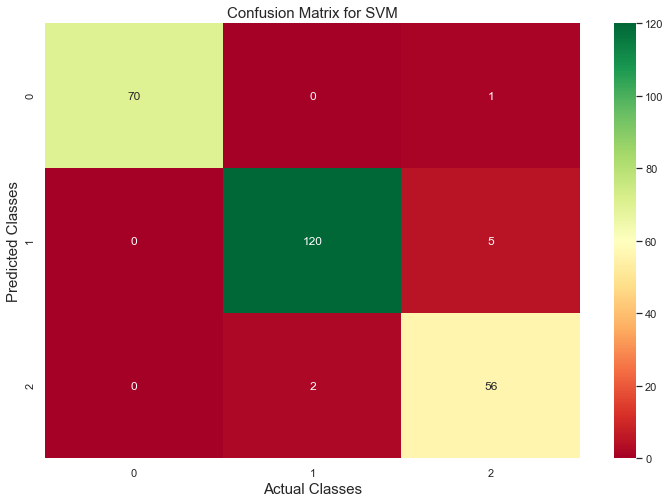

In [159]:
#visualization of confusion matrix in the form of a heatmap
cm= confusion_matrix(y_test, sv_test_predict)
plt.figure(figsize = (12, 8))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.xlabel('Actual Classes', fontsize = 15)
plt.ylabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for SVM', fontsize = 15);

In [160]:
#printing classification report
print("Classification Report")
print(metrics.classification_report(y_test, sv_test_predict, labels=[0,1,2]))

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        71
           1       0.98      0.96      0.97       125
           2       0.90      0.97      0.93        58

    accuracy                           0.97       254
   macro avg       0.96      0.97      0.97       254
weighted avg       0.97      0.97      0.97       254



In [161]:
precision_SV, recall_SV, f1_score_SV, support = precision_recall_fscore_support(y_test, sv_test_predict,average='macro')
print('Precision Score :', '%0.2f' % precision_SV)
print('Recall Score :', '%0.2f' % recall_SV)
print('F1-Score:', '%0.2f' % f1_score_SV)
SV_Acc= accuracy_score(y_test, sv_test_predict)
print('Accuracy Score :','%0.2f' % SV_Acc)

Precision Score : 0.96
Recall Score : 0.97
F1-Score: 0.97
Accuracy Score : 0.97


In [162]:
#SVM on the pca data
svc_model_pca = SVC(C= 4, kernel='rbf', gamma='scale')
svc_model_pca.fit(X_tr, y_tr)

SVC(C=4)

In [163]:
#predicting on train data
sv_tr_predict = svc_model_pca .predict(X_tr)
print("Model Accuracy on train: {0:.4f}".format(metrics.accuracy_score(y_tr, sv_tr_predict)))
print()

Model Accuracy on train: 0.9476



In [164]:
#predicting on test data
sv_te_predict = svc_model_pca .predict(X_te)
print("Model Accuracy on test: {0:.4f}".format(metrics.accuracy_score(y_te, sv_te_predict)))
print()

Model Accuracy on test: 0.9213



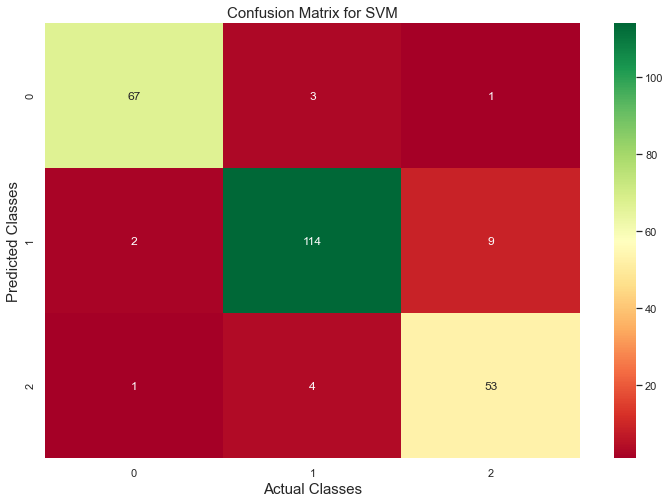

In [165]:
#visualization of confusion matrix in the form of a heatmap
cm= confusion_matrix(y_te, sv_te_predict)
plt.figure(figsize = (12, 8))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.xlabel('Actual Classes', fontsize = 15)
plt.ylabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for SVM', fontsize = 15);

In [166]:
#printing classification report
print("Classification Report")
print(metrics.classification_report(y_te, sv_te_predict, labels=[0,1,2]))

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        71
           1       0.94      0.91      0.93       125
           2       0.84      0.91      0.88        58

    accuracy                           0.92       254
   macro avg       0.91      0.92      0.92       254
weighted avg       0.92      0.92      0.92       254



In [167]:
precision_SV_pca, recall_SV_pca, f1_score_SV_pca, support_pca = precision_recall_fscore_support(y_te, sv_te_predict,average='macro')
print('Precision Score :', '%0.2f' % precision_SV_pca)
print('Recall Score :', '%0.2f' % recall_SV_pca)
print('F1-Score:', '%0.2f' % f1_score_SV_pca)
SV_Acc_pca= accuracy_score(y_te, sv_te_predict)
print('Accuracy Score :','%0.2f' % SV_Acc_pca)

Precision Score : 0.91
Recall Score : 0.92
F1-Score: 0.92
Accuracy Score : 0.92


In [168]:
modellists = []
modellists.append(['Support Vector Classifier without PCA', SV_Acc * 100, recall_SV * 100, precision_SV * 100,f1_score_SV*100])
modellists.append(['Support Vector Classifier with PCA', SV_Acc_pca* 100, recall_SV_pca * 100, precision_SV_pca * 100,f1_score_SV_pca*100])
mdl_df = pd.DataFrame(modellists, columns = ['Model','Accuracy Score of Test Data', 'Recall Score', 'Precision Score','F1 Score'])
mdl_df

Model  Accuracy Score of Test Data  \
0  Support Vector Classifier without PCA                    96.850394   
1     Support Vector Classifier with PCA                    92.125984   

   Recall Score  Precision Score   F1 Score  
0     97.047758        96.227745  96.596702  
1     92.315169        91.352049  91.773898

# 6. Conclusion: 
##     Showcase key pointer on how dimensional reduction helped in this case.

**Both the model give more than 90% accuracy on the test data, PCA used only 6 attributes to come up with an accuracy of 90%+ where as the model without pca used all the variables to come up with 90%+ accuracy, the difference can be illustrated even better if the dataset had been cursed with dimensionality, since its 18 variable in the original data the difference is very subtle.**

##                          

# PART IV

### DOMAIN: Sports management
### CONTEXT: 
Company X is a sports management company for international cricket.
### DATA DESCRIPTION: 
The data is collected belongs to batsman from IPL series conducted so far. Attribute Information:
1. Runs: Runs score by the batsman
2. Ave: Average runs scored by the batsman per match
3. SR: strike rate of the batsman
4. Fours: number of boundary/four scored
5. Six: number of boundary/six scored
6. HF: number of half centuries scored so far

### PROJECT OBJECTIVE: 
Goal is to build a data driven batsman ranking model for the sports management company to make business decisions.

In [169]:
#loading the required packages
import numpy as np   
import pandas as pd    
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from scipy.stats import zscore
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
%matplotlib inline 
sns.set(color_codes=True)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [170]:
#importing the data
bb=pd.read_csv('Part4 - batting_bowling_ipl_bat.csv')
#bb=bb.dropna(axis=0)
bb.head()

Name   Runs    Ave      SR  Fours  Sixes   HF
0        NaN    NaN    NaN     NaN    NaN    NaN  NaN
1   CH Gayle  733.0  61.08  160.74   46.0   59.0  9.0
2        NaN    NaN    NaN     NaN    NaN    NaN  NaN
3  G Gambhir  590.0  36.87  143.55   64.0   17.0  6.0
4        NaN    NaN    NaN     NaN    NaN    NaN  NaN

In [171]:
bb.isnull().sum()

Name     90
Runs     90
Ave      90
SR       90
Fours    90
Sixes    90
HF       90
dtype: int64

In [172]:
bb=bb.dropna(axis=0)
bb.head()

Name   Runs    Ave      SR  Fours  Sixes   HF
1   CH Gayle  733.0  61.08  160.74   46.0   59.0  9.0
3  G Gambhir  590.0  36.87  143.55   64.0   17.0  6.0
5   V Sehwag  495.0  33.00  161.23   57.0   19.0  5.0
7   CL White  479.0  43.54  149.68   41.0   20.0  5.0
9   S Dhawan  569.0  40.64  129.61   58.0   18.0  5.0

## 1. EDA and visualisation: 
**Create a detailed performance report using univariate, bi-variate and multivariate EDA techniques. Find out all possible hidden patterns by using all possible methods.**

In [173]:
#checking for the dimension of the data
rows, column = bb.shape
print('The dataset contains', rows, 'rows and', column, 'columns.')

The dataset contains 90 rows and 7 columns.


In [174]:
#checking for the data type
print('The data type of each attribute: \n')
bb.info()

The data type of each attribute: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 1 to 179
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    90 non-null     object 
 1   Runs    90 non-null     float64
 2   Ave     90 non-null     float64
 3   SR      90 non-null     float64
 4   Fours   90 non-null     float64
 5   Sixes   90 non-null     float64
 6   HF      90 non-null     float64
dtypes: float64(6), object(1)
memory usage: 5.6+ KB


In [175]:
#5-point summary
bb.describe().T

count        mean         std    min      25%      50%       75%  \
Runs    90.0  219.933333  156.253669   2.00   98.000  196.500  330.7500   
Ave     90.0   24.729889   13.619215   0.50   14.665   24.440   32.1950   
SR      90.0  119.164111   23.656547  18.18  108.745  120.135  131.9975   
Fours   90.0   19.788889   16.399845   0.00    6.250   16.000   28.0000   
Sixes   90.0    7.577778    8.001373   0.00    3.000    6.000   10.0000   
HF      90.0    1.188889    1.688656   0.00    0.000    0.500    2.0000   

          max  
Runs   733.00  
Ave     81.33  
SR     164.10  
Fours   73.00  
Sixes   59.00  
HF       9.00

In [176]:
print('Duplicated rows: ', bb[bb.duplicated()].shape[0])

Duplicated rows:  0


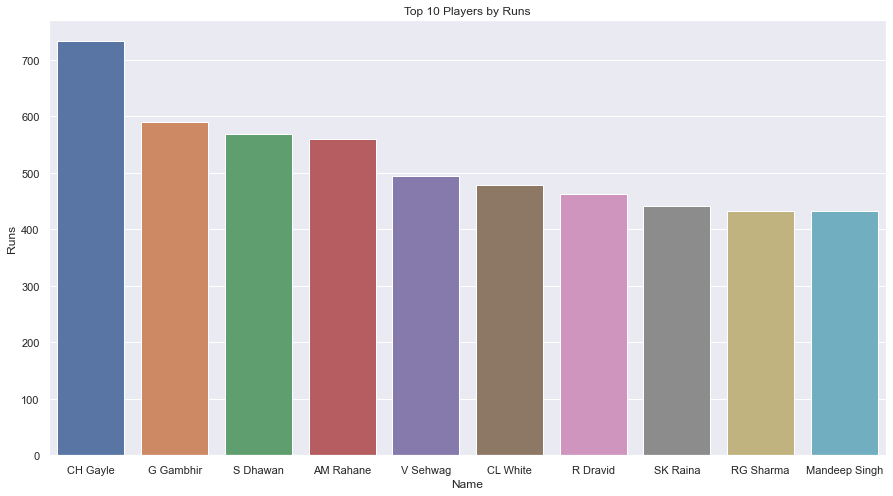

In [177]:
plt.figure(figsize=(15,8))
b1=bb.groupby('Name')['Runs'].sum().sort_values(ascending = False ).head(10)
b1= b1.reset_index() 
b1.columns = ['Name' ,'Runs']
sns.barplot(data= b1 , x= 'Name' , y ='Runs');
plt.title("Top 10 Players by Runs");

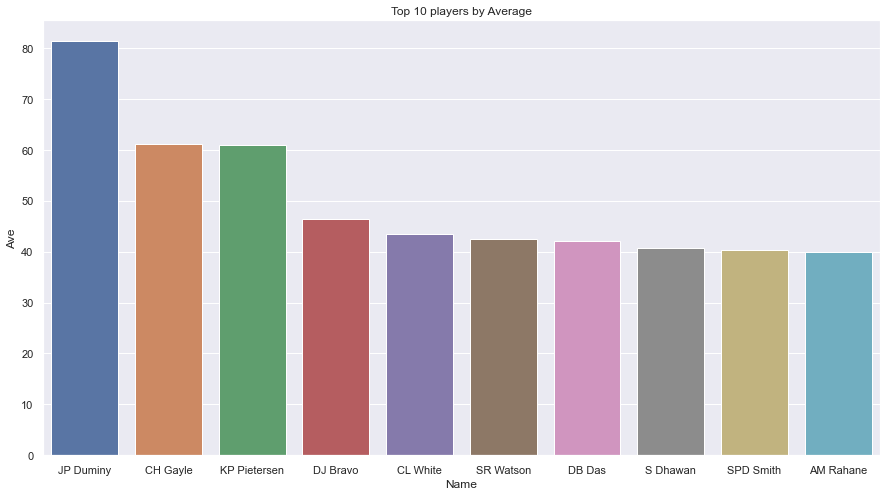

In [178]:
plt.figure(figsize=(15,8))
b1=bb.groupby('Name')['Ave'].sum().sort_values(ascending = False ).head(10)
b1= b1.reset_index() 
b1.columns = ['Name' ,'Ave']
sns.barplot(data= b1 , x= 'Name' , y ='Ave')
plt.title("Top 10 players by Average");

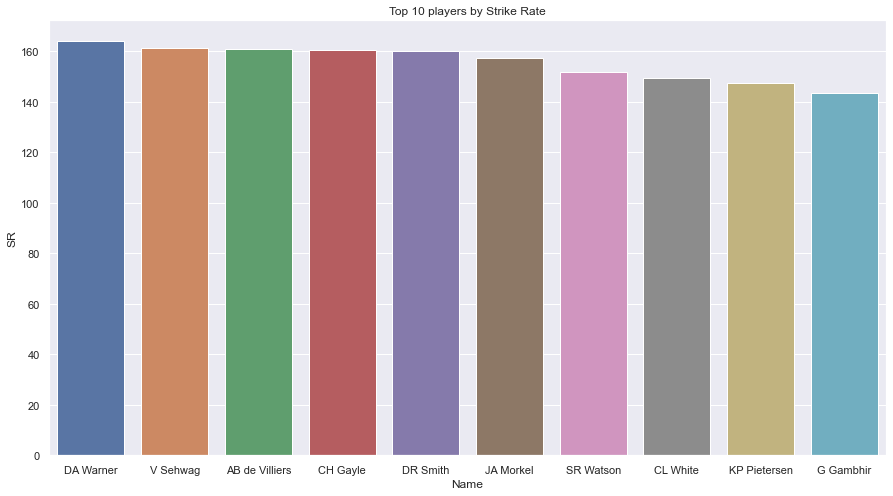

In [179]:
plt.figure(figsize=(15,8))
b1=bb.groupby('Name')['SR'].sum().sort_values(ascending = False ).head(10)
b1= b1.reset_index() 
b1.columns = ['Name' ,'SR']
sns.barplot(data= b1 , x= 'Name' , y ='SR')
plt.title("Top 10 players by Strike Rate");

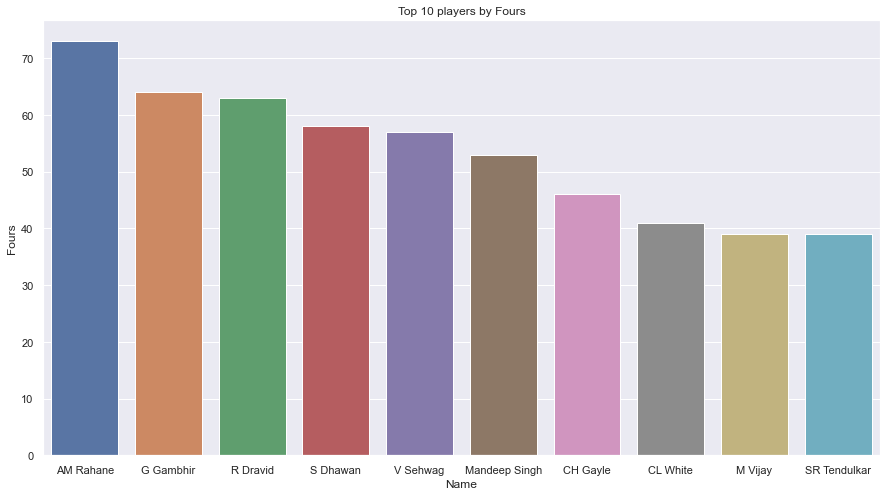

In [180]:
plt.figure(figsize=(15,8))
b1=bb.groupby('Name')['Fours'].sum().sort_values(ascending = False ).head(10)
b1= b1.reset_index() 
b1.columns = ['Name' ,'Fours']
sns.barplot(data= b1 , x= 'Name' , y ='Fours')
plt.title("Top 10 players by Fours");

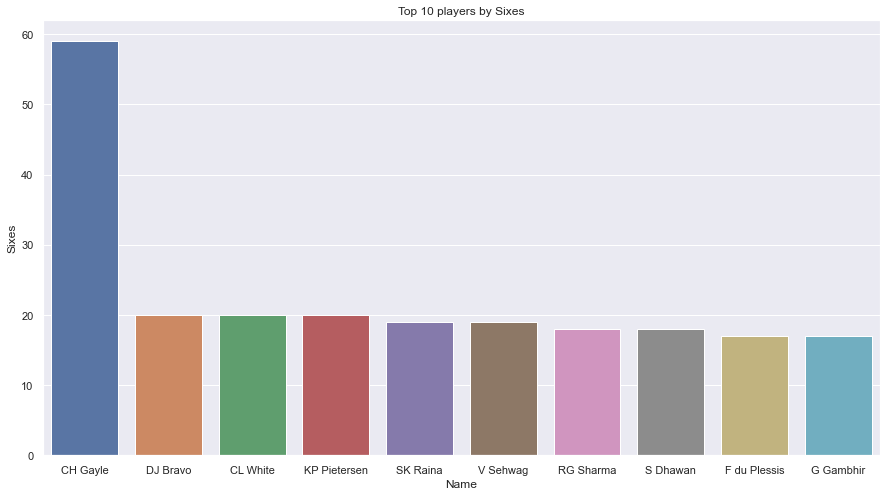

In [181]:
plt.figure(figsize=(15,8))
b1=bb.groupby('Name')['Sixes'].sum().sort_values(ascending = False ).head(10)
b1= b1.reset_index() 
b1.columns = ['Name' ,'Sixes']
sns.barplot(data= b1 , x= 'Name' , y ='Sixes')
plt.title("Top 10 players by Sixes");

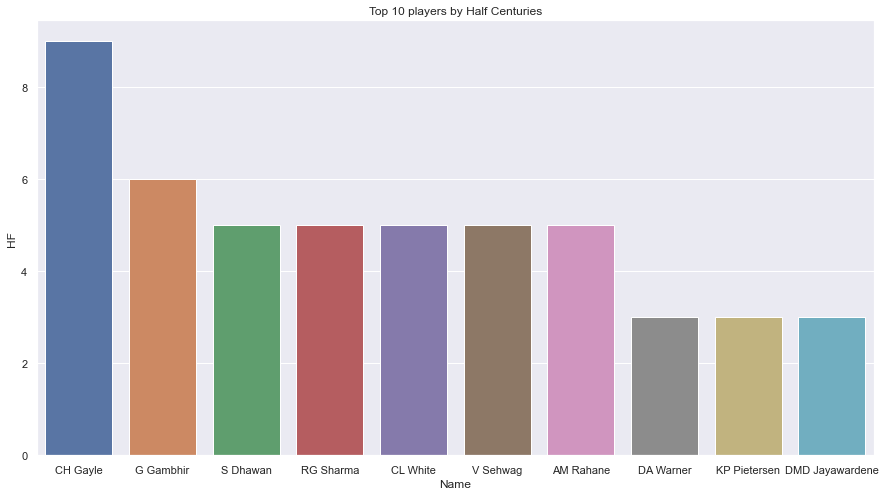

In [182]:
plt.figure(figsize=(15,8))
b1=bb.groupby('Name')['HF'].sum().sort_values(ascending = False ).head(10)
b1= b1.reset_index() 
b1.columns = ['Name' ,'HF']
sns.barplot(data= b1 , x= 'Name' , y ='HF')
plt.title("Top 10 players by Half Centuries");

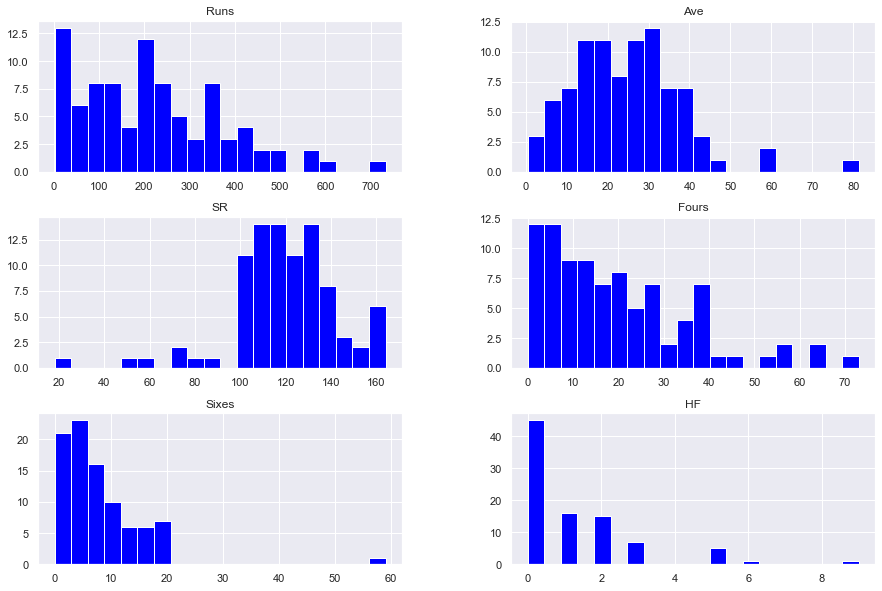

In [183]:
bb.hist(bins = 20, figsize = (15, 10), color = 'blue')
plt.show()

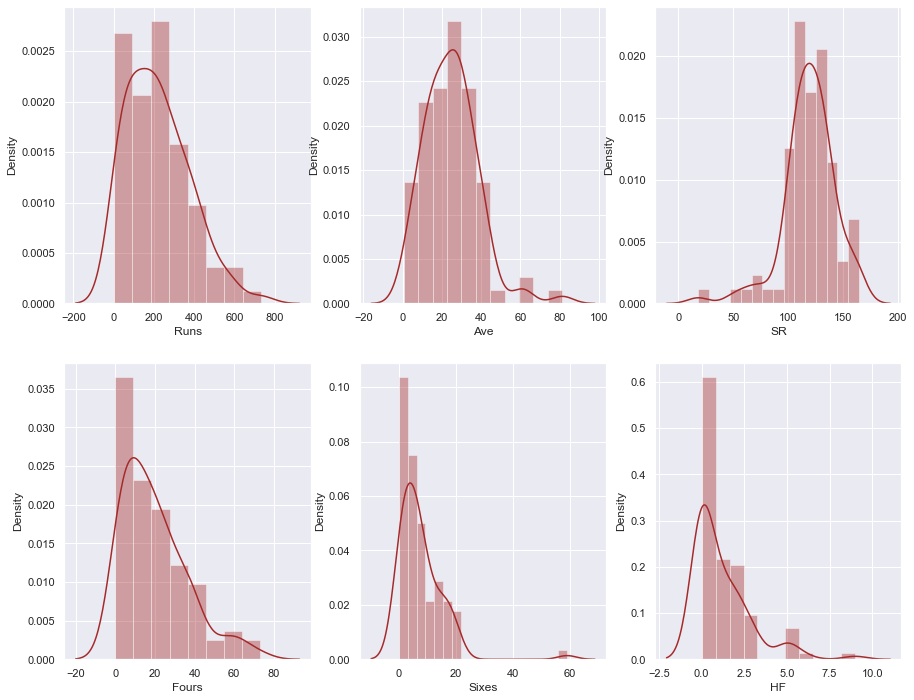

In [184]:
plt.figure(figsize=(15, 12))
col = 1
for i in bb.drop(columns='Name').columns:
    plt.subplot(2, 3, col)
    sns.distplot(bb[i], color = 'brown')
    col += 1 

**Strike rate, fours, sixes and half centuries have a skewed distribution**

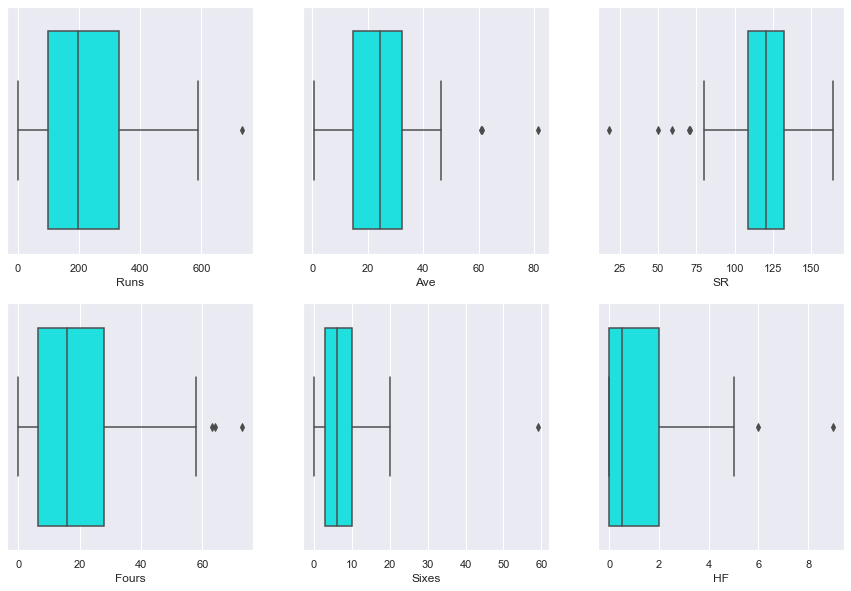

In [185]:
plt.figure(figsize=(15, 10))
col = 1
for i in bb.drop(columns='Name').columns:
    plt.subplot(2, 3, col)
    sns.boxplot(bb[i],color='cyan')
    col += 1

**There appears to be outliers, will not be treating them as its highly likely that these are genuine observation**

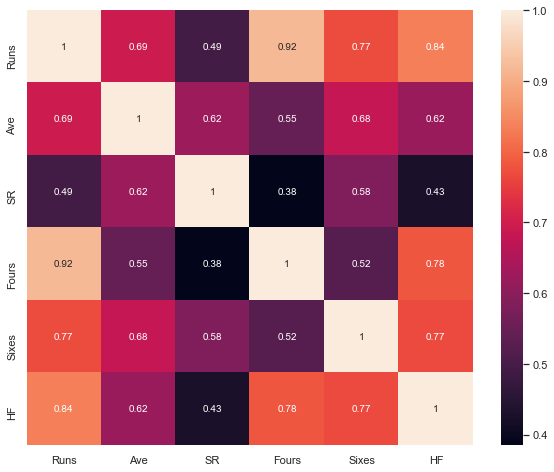

In [186]:
#checking for correlation
plt.figure(figsize=(10,8))
corr=bb.drop(columns='Name').corr()
sns.heatmap(corr,annot=True);

**All the variable except fours with strike rate, strike rate with half centuries,strike rate with runs, have high correlation**

## 2. Build a data driven model to rank all the players in the dataset using all or the most important performance features

In [187]:
#scaling the numeric variables
cc = bb.iloc[:,1:7] 
cc1 = cc.apply(zscore)
cc1.head()

Runs       Ave        SR     Fours     Sixes        HF
1  3.301945  2.683984  1.767325  1.607207  6.462679  4.651551
3  2.381639  0.896390  1.036605  2.710928  1.184173  2.865038
5  1.770248  0.610640  1.788154  2.281703  1.435530  2.269533
7  1.667276  1.388883  1.297182  1.300618  1.561209  2.269533
9  2.246490  1.174755  0.444038  2.343021  1.309851  2.269533

In [188]:
#checking for the within sum of squares
wss =[] 
for i in range(1,6):
    KM = KMeans(n_clusters=i)
    KM.fit(cc1)
    wss.append(KM.inertia_)
wss

[540.0,
 296.2613535473202,
 223.36518460916955,
 178.17507967590407,
 144.6843005115307]

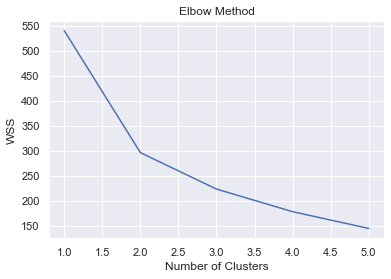

In [189]:
#plotting to check for optimal clusters 
plt.plot(range(1,6), wss);
plt.title('Elbow Method');
plt.xlabel("Number of Clusters")
plt.ylabel("WSS");

In [190]:
#using 2 centroids
k_means = KMeans(n_clusters = 2)
k_means.fit(cc1)
labels = k_means.labels_

In [191]:
# Calculating silhouette_score
silhouette_score(cc1,labels)

0.41111085574076756

In [192]:
#plotting silhouette score for different centroids
kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
}


silhouette_coefficients = []

 # Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(cc1)
    score = silhouette_score(cc1,kmeans.labels_)
    silhouette_coefficients.append(score)
    
silhouette_coefficients

[0.41111085574076756,
 0.3749672949562151,
 0.2897849787117253,
 0.3447282147194914]

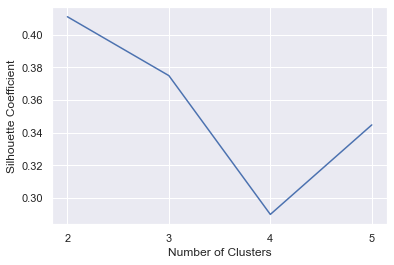

In [193]:
plt.plot(range(2,6), silhouette_coefficients)
plt.xticks(range(2, 6))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [194]:
#attaching the labels to the original data
bb['cluster']=labels
bb.head()

Name   Runs    Ave      SR  Fours  Sixes   HF  cluster
1   CH Gayle  733.0  61.08  160.74   46.0   59.0  9.0        0
3  G Gambhir  590.0  36.87  143.55   64.0   17.0  6.0        0
5   V Sehwag  495.0  33.00  161.23   57.0   19.0  5.0        0
7   CL White  479.0  43.54  149.68   41.0   20.0  5.0        0
9   S Dhawan  569.0  40.64  129.61   58.0   18.0  5.0        0

In [195]:
#veiwing the distribution of the clusters
bb.cluster.value_counts().sort_index()

0    35
1    55
Name: cluster, dtype: int64

In [196]:
#aggregating the clusters with the numeric variables with their mean
aggdata=bb.iloc[:,0:9].groupby('cluster').mean()
aggdata['Freq']=bb.cluster.value_counts().sort_index()
aggdata

Runs        Ave          SR      Fours      Sixes        HF  \
cluster                                                                      
0        372.657143  35.962286  132.808286  34.685714  13.771429  2.714286   
1        122.745455  17.582000  110.481455  10.309091   3.636364  0.218182   

         Freq  
cluster        
0          35  
1          55

In [197]:
#based on the above table renaming/ranking the playes in Grade A and Grade B
bb['cluster'] = bb['cluster'].replace({1: 'Grade A', 0: 'Grade B'})

In [198]:
#list of Grade A players
Grade_A = bb[bb['cluster'] == 'Grade A']
Grade_A.head(10)

Name   Runs    Ave      SR  Fours  Sixes   HF  cluster
69       MS Bisla  213.0  30.42  133.12   16.0   10.0  1.0  Grade A
73       BJ Hodge  245.0  30.62  140.00   18.0    9.0  0.0  Grade A
75        NV Ojha  255.0  23.18  113.83   21.0   13.0  1.0  Grade A
77         DB Das  126.0  42.00  135.48    9.0    6.0  0.0  Grade A
79   AC Gilchrist  172.0  34.40  120.27   21.0    4.0  1.0  Grade A
81    BB McCullum  289.0  24.08  102.12   37.0    3.0  1.0  Grade A
83      IK Pathan  176.0  25.14  139.68   14.0    6.0  0.0  Grade A
85  Azhar Mahmood  186.0  23.25  130.98   16.0    8.0  0.0  Grade A
87      MK Pandey  143.0  20.42  127.67   12.0    6.0  1.0  Grade A
89    S Badrinath  196.0  28.00  108.28   23.0    2.0  1.0  Grade A

In [199]:
#list of Grade B players
Grade_B = bb[bb['cluster'] == 'Grade B']
Grade_B.head()

Name   Runs    Ave      SR  Fours  Sixes   HF  cluster
1   CH Gayle  733.0  61.08  160.74   46.0   59.0  9.0  Grade B
3  G Gambhir  590.0  36.87  143.55   64.0   17.0  6.0  Grade B
5   V Sehwag  495.0  33.00  161.23   57.0   19.0  5.0  Grade B
7   CL White  479.0  43.54  149.68   41.0   20.0  5.0  Grade B
9   S Dhawan  569.0  40.64  129.61   58.0   18.0  5.0  Grade B

# 

# PART V

### 1. List down all possible dimensionality reduction techniques that can be implemented using python.

## Dimensionality Reduction Techniques:

1.   **Feature selection**

        * **EDA & Visualization** thru univariate, bivariate analysis and correlation heatmaps
             * Scikit -> VarianceThreshold(), SelectKBest, SelectPercentile, GenericUnivariateSelect
             * Statistical tests/measures -> ANOVA, Chi-square, F-Test, Pearson’s coefficient, Maximal Information Coefficient 
               etc)         
         
2.   **Feature Engineering**

        * **Linear Dimensionality Reduction Methods**
        * **PCA** (Principal Component Analysis)
        
          - **SVD** (Singular Value Decomposition) – Sparse data matrices
          - **Factor Analysis** (Higher-D features are caused by low-D factors)
          - **Linear Discriminant Analysis (LDA)** -> (Linear projection of data to improve class separability)

        * **Non-Linear Dimensionality Reduction Methods**
          - **MDS** (Multi-Dimensional Scaling) -> Condense dimensions while keeping “similarity” Eucl-dist. intact
          - **Isometric Feature mapping (Isomap)** -> Same as above except “geodesic” distance measure
          - **Locally Linear Embedding (LLE/ HLLE)** -> Projects data to lower-D while preserving the local neighborhoods in 
            data, HLLE is using special Hessian operator (Hessian Eigen-mapping)
          - **Spectral Embedding** (Laplacian Eigenmaps) – Spectral techniques to map nearby I/ps -> nearby O/ps
          - **t-SNE** (t-Distributed Stochastic Neighbor Embedding) – Gaussian Prob. dist. to relate data pairs in higher-D  
            transform to lower-D embedding preserving similar distribution and clustering -> great for 2D visualizations

        * **ANN** (Artificial Neural Networks) based **Auto-encoders**
        
        * Latent Semantic Analysis
        * Non-negative matrix factorization (NMF)
        * Generalized discriminant analysis (GDA)
        * Missing Values Ratio
        * Low Variance Filter
        * High Correlation Filter
        * Backward Feature Elimination
        * Forward Feature Construction
        * Random Forests


### 2. So far you have used dimensional reduction on numeric data. Is it possible to do the same on a multimedia data [images and video] and text data ? Please illustrate your findings using a simple implementation on python.

       Yes, We can Use PCA. for example: we are applying the PCA on Image Data and hand written digits.

## Application: Exploring Handwritten Digits

In [200]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.images.shape

(1797, 8, 8)

**The images data is a three-dimensional array: 1,797 samples, each consisting of an 8×8 grid of pixels**

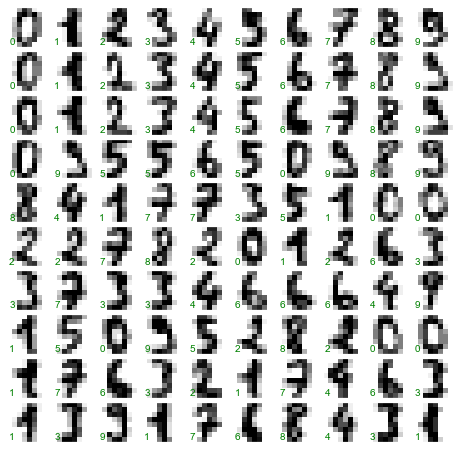

In [201]:
# visualize the first hundred of these
import matplotlib.pyplot as plt
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
subplot_kw={'xticks':[], 'yticks':[]},
gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i,ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]),
    transform=ax.transAxes, color='green')

In [202]:
#two-dimensional,[n_samples, n_features] representation
X = digits.data
X.shape

(1797, 64)

In [203]:
y = digits.target
y.shape

(1797,)

**1,797 samples and 64 features.**

In [204]:
#transform the data to two dimensions using manifold learning algorithm called Isomap
from sklearn.manifold import Isomap
iso = Isomap(n_components=2)
iso.fit(digits.data)
data_projected = iso.transform(digits.data)
data_projected.shape

(1797, 2)

**The projected data is now two-dimensional**

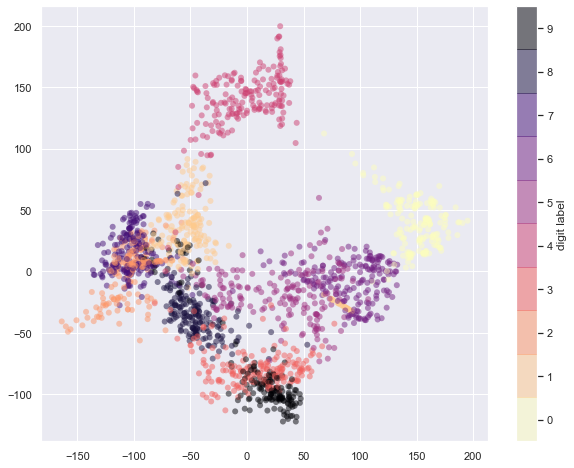

In [205]:
# plot this data to see if we can learn anything from its structure 
plt.figure(figsize=(10, 8))
plt.scatter(data_projected[:, 0], data_projected[:, 1], c=digits.target,edgecolor='none', alpha=0.5,cmap=plt.cm.get_cmap('magma_r', 10))
plt.colorbar(label='digit label', ticks=range(10))
plt.clim(-0.5, 9.5);

In [206]:
from sklearn.model_selection import train_test_split
 # Split X and y into training and test set in 70:30 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=15)

In [207]:
#fit a Gaussian naive Bayes model
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [208]:
# gauge its accuracy by comparing the true values of the test set to the predictions
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred)

0.8407407407407408

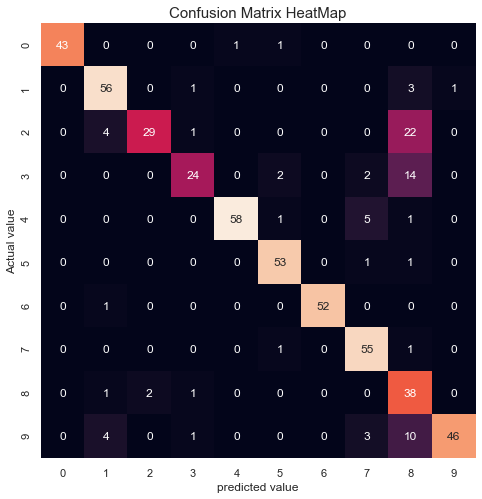

In [209]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline 
sns.set(color_codes=True)
#visualization of confusion matrix in the form of a heatmap
plt.figure(figsize = (12, 8))
mat = confusion_matrix(y_test, pred)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('Actual value');
plt.title('Confusion Matrix HeatMap', fontsize = 15);

**This shows us where the mislabeled points tend to be: for example, a large number of twos here are misclassified as either ones or eights**

**Another way to gain intuition into the characteristics of the model is to plot the inputs again, with their predicted labels. We’ll use green for correct labels, and red for incorrect labels**

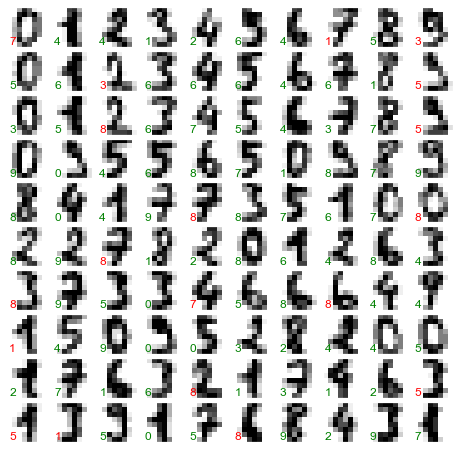

In [210]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
 subplot_kw={'xticks':[], 'yticks':[]},
 gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(pred[i]),
    transform=ax.transAxes,
    color='green' if (y_test[i] == pred[i]) else 'red')

## 

## PCA on Image Data

(1323, 1500, 3)


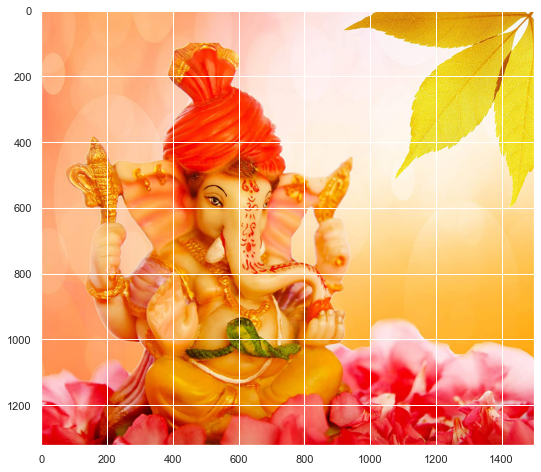

In [211]:
import numpy as np
from matplotlib.image import imread
import matplotlib.pyplot as plt

image_raw = imread('ganesha.jpg')
print(image_raw.shape)

# Displaying the image
plt.figure(figsize=[12,8])
plt.imshow(image_raw)

(1323, 1500)
1.0


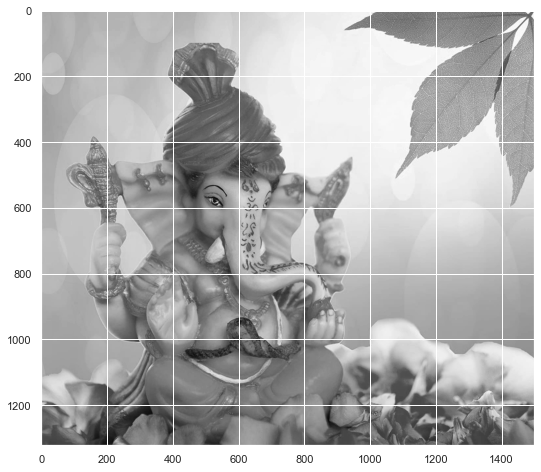

In [212]:
image_sum = image_raw.sum(axis=2)
print(image_sum.shape)

image_bw = image_sum/image_sum.max()
print(image_bw.max())

plt.figure(figsize=[12,8])
plt.imshow(image_bw, cmap=plt.cm.gray)

Number of components explaining 95% variance: 44


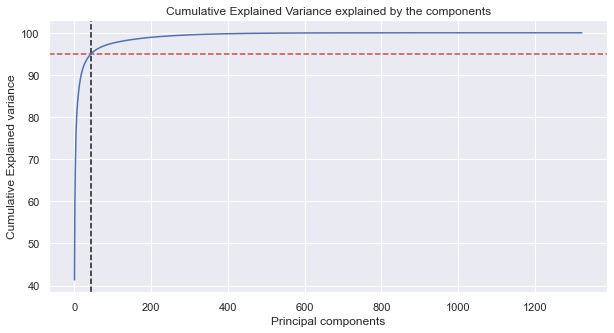

In [213]:
from sklearn.decomposition import PCA, IncrementalPCA
pca = PCA()
pca.fit(image_bw)

# Getting the cumulative variance

var_cumu = np.cumsum(pca.explained_variance_ratio_)*100

# How many PCs explain 95% of the variance?
k = np.argmax(var_cumu>95)
print("Number of components explaining 95% variance: "+ str(k))
#print("\n")

plt.figure(figsize=[10,5])
plt.title('Cumulative Explained Variance explained by the components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=95, color="r", linestyle="--")
ax = plt.plot(var_cumu)

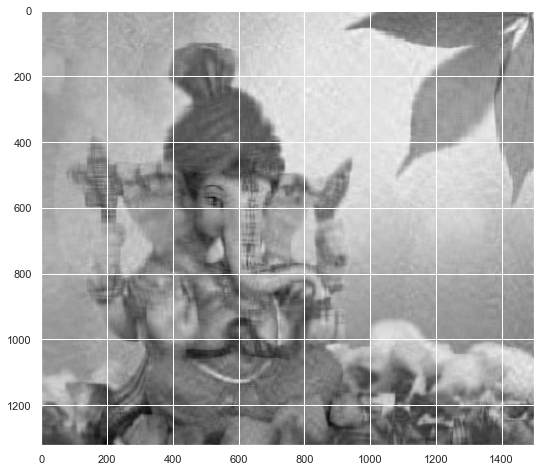

In [214]:
ipca = IncrementalPCA(n_components=k)
image_recon = ipca.inverse_transform(ipca.fit_transform(image_bw))

# Plotting the reconstructed image
plt.figure(figsize=[12,8])
plt.imshow(image_recon,cmap = plt.cm.gray)

**Let's try out a different value of k - 150 components**

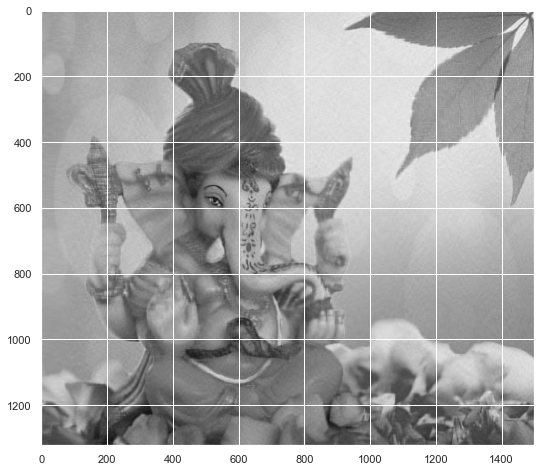

In [215]:
# Function to reconstruct and plot image for a given number of components

def plot_at_k(k):
    ipca = IncrementalPCA(n_components=k)
    image_recon = ipca.inverse_transform(ipca.fit_transform(image_bw))
    plt.imshow(image_recon,cmap = plt.cm.gray)
    

k = 150
plt.figure(figsize=[12,8])
plot_at_k(100)

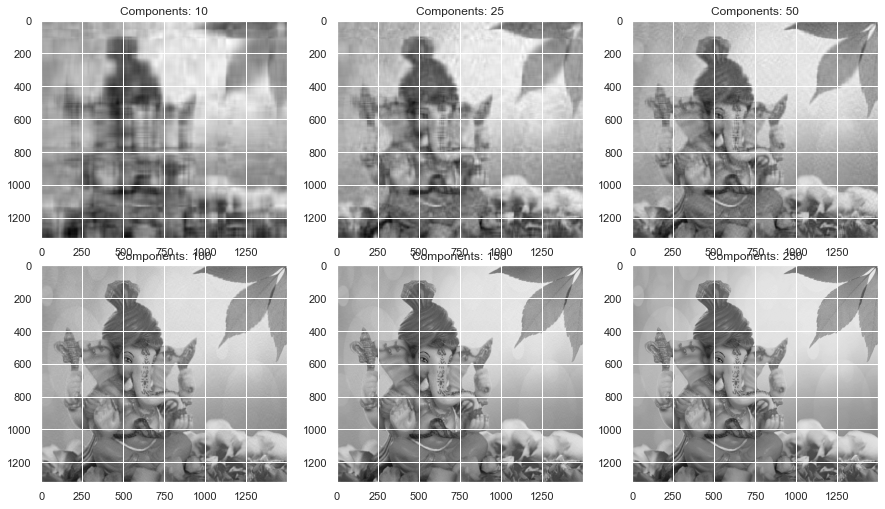

In [216]:
ks = [10, 25, 50, 100, 150, 250]

plt.figure(figsize=[15,9])

for i in range(6):
    plt.subplot(2,3,i+1)
    plot_at_k(ks[i])
    plt.title("Components: "+str(ks[i]))

plt.subplots_adjust(wspace=0.2, hspace=0.0)
plt.show()

                                               End